In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.saving.saved_model_experimental import models_lib

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Using UTF-8 for loading because some driver names and track names have weird characters
df = pd.read_csv('data/archive/f1_pitstops_2018_2024.csv', encoding='utf-8', delimiter=',')

In [3]:
df.head(len(df))

,Season,Round,Circuit,Driver,Constructor,Laps,Position,TotalPitStops,AvgPitStopTime,Race Name,...,Tire Usage Aggression,Fast Lap Attempts,Position Changes,Driver Aggression Score,Abbreviation,Stint,Tire Compound,Stint Length,Pit_Lap,Pit_Time
0,2018,1,Albert Park Grand Prix Circuit,Sebastian Vettel,Ferrari,58,1,1,21.787,Australian Grand Prix,...,0.017241,44.76882,0.000000,6.755003,VET,1.0,ULTRASOFT,25.0,26.0,21.787
1,2018,1,Albert Park Grand Prix Circuit,Sebastian Vettel,Ferrari,58,1,1,21.787,Australian Grand Prix,...,0.017241,44.76882,0.000000,6.755003,VET,2.0,SOFT,32.0,NaN,Final Stint
2,2018,1,Albert Park Grand Prix Circuit,Lewis Hamilton,Mercedes,58,2,1,21.821,Australian Grand Prix,...,0.017241,44.73482,0.043478,6.754254,HAM,1.0,ULTRASOFT,17.0,19.0,21.821
3,2018,1,Albert Park Grand Prix Circuit,Lewis Hamilton,Mercedes,58,2,1,21.821,Australian Grand Prix,...,0.017241,44.73482,0.043478,6.754254,HAM,2.0,SOFT,39.0,NaN,Final Stint
4,2018,1,Albert Park Grand Prix Circuit,Kimi RÃƒÂ¤ikkÃƒÂ¶nen,Ferrari,58,3,1,21.421,Australian Grand Prix,...,0.017241,45.13482,0.086957,6.818562,RAI,1.0,ULTRASOFT,17.0,18.0,21.421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7369,2024,24,Yas Marina Circuit,Valtteri Bottas,Sauber,30,18,1,41.144,Abu Dhabi Grand Prix,...,0.033333,25.41182,0.739130,3.930495,BOT,1.0,MEDIUM,6.0,6.0,41.144
7370,2024,24,Yas Marina Circuit,Valtteri Bottas,Sauber,30,18,1,41.144,Abu Dhabi Grand Prix,...,0.033333,25.41182,0.739130,3.930495,BOT,2.0,HARD,24.0,NaN,Final Stint
7371,2024,24,Yas Marina Circuit,Franco Colapinto,Williams,26,19,1,24.941,Abu Dhabi Grand Prix,...,0.038462,41.61482,0.782609,6.364719,COL,1.0,MEDIUM,3.0,3.0,24.941
7372,2024,24,Yas Marina Circuit,Franco Colapinto,Williams,26,19,1,24.941,Abu Dhabi Grand Prix,...,0.038462,41.61482,0.782609,6.364719,COL,2.0,HARD,23.0,NaN,Final Stint


In [4]:
# Basic dataset information
print(f"Dataset dimensions: {df.shape}")
print(f"\nDuplicate entries: {df.duplicated().sum()}")
print(f"\nUnique drivers: {df['Driver'].nunique()}")
print(f"\nUnique constructors: {df['Constructor'].nunique()}")
print(f"\nUnique circuits: {df['Circuit'].nunique()}")
print(f"\nSeasons covered: {df['Season'].nunique()} ({df['Season'].min()}-{df['Season'].max()})")

Dataset dimensions: (7374, 30)

Duplicate entries: 0

Unique drivers: 40

Unique constructors: 16

Unique circuits: 31

Seasons covered: 7 (2018-2024)


# Dataset Feature Description

* **Season --** Year of the Formula 1 Season
* **Round --** Race number within the Formula 1 season (in question)
* **Circuit --** At what circuit the race was held (with respect to the country)   
* **Driver --** Full name of the Driver
* **Constructor --** Registered name of the Constructor taking participating in the race (Car Manufacturer/Team)
* **Laps --** Number of Laps completed
* **Position --** Finishing position of the driver
* **TotalPitStops --** Total number of pit stops taken by the driver 
* **Race Name --** Name of the Race at the circuit
* **Date --** Date of the race
* **Time_of_race --** Time of the race
* **Location --** Location of the race (in that Country)
* **Country --** Demographic Location on Earth
* **Air_Temp_C --** Average Air Temperature during the race (°C)
* **Track_Temp_C --** Average Track Temperature during the race (°C)
* **Humidity_% --** Measured Humidity (%)
* **Wind_Speed_KMH --** Measured Wind Speed
* **Lap Time Variation --** Variation of the driver's lap times during the race
* **Total Pit Stops --** Total number of pit stops by the driver
* **Tire Usage Aggression --** Aggression score is a reflection of the longitudinal g-force each driver generates, both through acceleration and retardation
* **Fast Lap Attempts --** Total number of attempts for Fastest Lap of the race
* **Position Changes --** Frequency of race position changes
* **Driver Aggression Score --** Driver aggression score
* **Abbreviation --** Abbreviation of the driver name (usually three characters)
* **Stint --** Period a driver spends on the track between pit stops (Pit stop count basically which is Nominal) 
* **Tyre Compound --** Type of tyre fitted on the car for that stint
* **Stint Length --** Total Laps in the stint
* **Pit_Lap --** Lap when driver enters the pits (Nominal feature)
* **Pit Time --** Time spent in the pit lanes (s)

## A bit of a lecture for context

In this dataset there are a few things to know for context

The dataset is understood to be divided into 6 major parts (6 seasons), 22 subparts (22 rounds each season) and depending on how many pitstops a 
driver makes, a data entry is created.

# RULES
***A DRIVER MUST USE AT LEAST TWO TYRE COMPOUNDS DURING A RACE***, meaning there's only $(n - 1)$ pit-stops for every entry present

### TYRES
Tyres come in different types known as compounds. Tyre compounds go from SUPER-HARD to HYPER-SOFT (Until after the 2019 Season), with later compounds made simpler - (HARD - SOFT)
* HARD (or SUPER HARD) -> Least amount of grip, Longest life span
* SOFT (or HYPER SOFT) -> Strongest grip, Shortest life span

However these are logically used in dry conditions, during damp or wet conditions teams have two choices:
* INTERMEDIATE -> Provides the most grip in wet conditions while maintaining the most downforce
* WET -> Provides grip, while clearing standing water on track (When it's raining cats 'n dogs)


**This Notebook aims to predict the finishing position of a driver**

The dataset has a fine and nice feature divide, as such:
* #### Driver Performance Metrics
    * Tire Usage Aggression 
    * Fast Lap Attempts
    * Driver Aggression Scores
    * Position Changes
    * Position

* #### Race Data
    * Laps
    * Stint Length
    * Pit Time

* #### Race conditions
    * Air Temperature
    * Track Temperature
    * Humidity
    * Wind Speed (Km/h)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7374 entries, 0 to 7373
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Season                   7374 non-null   int64  
 1   Round                    7374 non-null   int64  
 2   Circuit                  7374 non-null   object 
 3   Driver                   7374 non-null   object 
 4   Constructor              7374 non-null   object 
 5   Laps                     7374 non-null   int64  
 6   Position                 7374 non-null   int64  
 7   TotalPitStops            7374 non-null   int64  
 8   AvgPitStopTime           7189 non-null   float64
 9   Race Name                7001 non-null   object 
 10  Date                     7001 non-null   object 
 11  Time_of_race             7001 non-null   object 
 12  Location                 7001 non-null   object 
 13  Country                  7001 non-null   object 
 14  Air_Temp_C              

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Season,7374.0,2021.308245,1.969604,2018.000000,2020.000000,2021.000000,2023.000000,2024.000000
Round,7374.0,10.673312,6.135126,1.000000,5.000000,11.000000,15.000000,24.000000
Laps,7374.0,56.643748,13.922667,0.000000,52.000000,57.000000,66.000000,87.000000
Position,7374.0,10.156089,5.590062,1.000000,5.000000,10.000000,15.000000,20.000000
TotalPitStops,7374.0,2.068348,1.135088,0.000000,1.000000,2.000000,3.000000,7.000000
AvgPitStopTime,7189.0,120.109095,268.723688,17.358500,22.388000,24.414000,30.068000,3055.732000
Air_Temp_C,7001.0,19.520345,5.092982,0.387500,15.958333,19.633333,23.750000,33.295833
Track_Temp_C,7001.0,25.207104,5.195562,5.887500,21.587500,25.175000,29.504167,39.795833
Humidity_%,7001.0,67.576191,14.157319,18.375000,60.500000,70.500000,77.291667,94.333333
Wind_Speed_KMH,7001.0,11.434032,6.073363,3.362500,6.804167,9.408333,15.550000,35.908333


In [7]:
print(df.isna().sum())

Season                        0
Round                         0
Circuit                       0
Driver                        0
Constructor                   0
Laps                          0
Position                      0
TotalPitStops                 0
AvgPitStopTime              185
Race Name                   373
Date                        373
Time_of_race                373
Location                    373
Country                     373
Air_Temp_C                  373
Track_Temp_C                373
Humidity_%                  373
Wind_Speed_KMH              373
Lap Time Variation          185
Total Pit Stops               0
Tire Usage Aggression        66
Fast Lap Attempts           185
Position Changes              0
Driver Aggression Score     185
Abbreviation                  0
Stint                       109
Tire Compound               109
Stint Length                109
Pit_Lap                    2810
Pit_Time                    281
dtype: int64


Numerical Columns with missing values will be handled with the imputation of mean or median values depending on it's use
Categorical columns will also be handled similarly with a few other logic to be ap|plied

In [8]:
# DUPLICATES
print(f'Duplicates in dataframe: {df.duplicated().sum()}, ({np.round(100 * df.duplicated().sum() / len(df), 1)}%)')

Duplicates in dataframe: 0, (0.0%)


No duplicates, Sjajno

In [9]:
df.nunique()

Season                        7
Round                        24
Circuit                      31
Driver                       40
Constructor                  16
Laps                         78
Position                     20
TotalPitStops                 8
AvgPitStopTime             2492
Race Name                    30
Date                        134
Time_of_race                 26
Location                     27
Country                      24
Air_Temp_C                  132
Track_Temp_C                132
Humidity_%                  128
Wind_Speed_KMH              132
Lap Time Variation         2492
Total Pit Stops               8
Tire Usage Aggression       153
Fast Lap Attempts          2492
Position Changes             20
Driver Aggression Score    2636
Abbreviation                 38
Stint                         8
Tire Compound                 9
Stint Length                 72
Pit_Lap                      71
Pit_Time                   3841
dtype: int64

There's 24 Rounds every season. Taking the most prominent tracks/rounds from each season, I'll try to form a trend or relationship between the features:
Relevant columns and the target. This is mostly because some tracks (rounds) weren't constant the whole 7 seasons, however some were.

In [10]:
# print(df['Pit_Time'].sample(100).tolist())

In [11]:
print(df.isna().sum())

Season                        0
Round                         0
Circuit                       0
Driver                        0
Constructor                   0
Laps                          0
Position                      0
TotalPitStops                 0
AvgPitStopTime              185
Race Name                   373
Date                        373
Time_of_race                373
Location                    373
Country                     373
Air_Temp_C                  373
Track_Temp_C                373
Humidity_%                  373
Wind_Speed_KMH              373
Lap Time Variation          185
Total Pit Stops               0
Tire Usage Aggression        66
Fast Lap Attempts           185
Position Changes              0
Driver Aggression Score     185
Abbreviation                  0
Stint                       109
Tire Compound               109
Stint Length                109
Pit_Lap                    2810
Pit_Time                    281
dtype: int64


In [12]:
# First, fix encoding issues
name_encoding_fixes = {
    'Kimi RÃƒÂ¤ikkÃƒÂ¶nen': 'Kimi Räikkönen',
    'Nico HÃƒÂ¼lkenberg': 'Nico Hülkenberg',
    'Sergio PÃƒÂ©rez': 'Sergio Pérez'
}

track_encoding_fixes = {
    'AutÃƒÂ³dromo Hermanos RodrÃƒÂ­guez': 'Autódromo Hermanos Rodríguez',
    'AutÃƒÂ³dromo Internacional do Algarve': 'Autódromo Internacional do Algarve',
    'NÃƒÂ¼rburgring': 'Nürburgring',
    'AutÃƒÂ³dromo JosÃƒÂ© Carlos Pace': 'Autódromo José Carlos Pace'
}

for incorrect, correct in name_encoding_fixes.items():
    df['Driver'] = df['Driver'].replace(incorrect, correct)

for incorrect, correct in track_encoding_fixes.items():
    df['Circuit'] = df['Circuit'].replace(incorrect, correct)

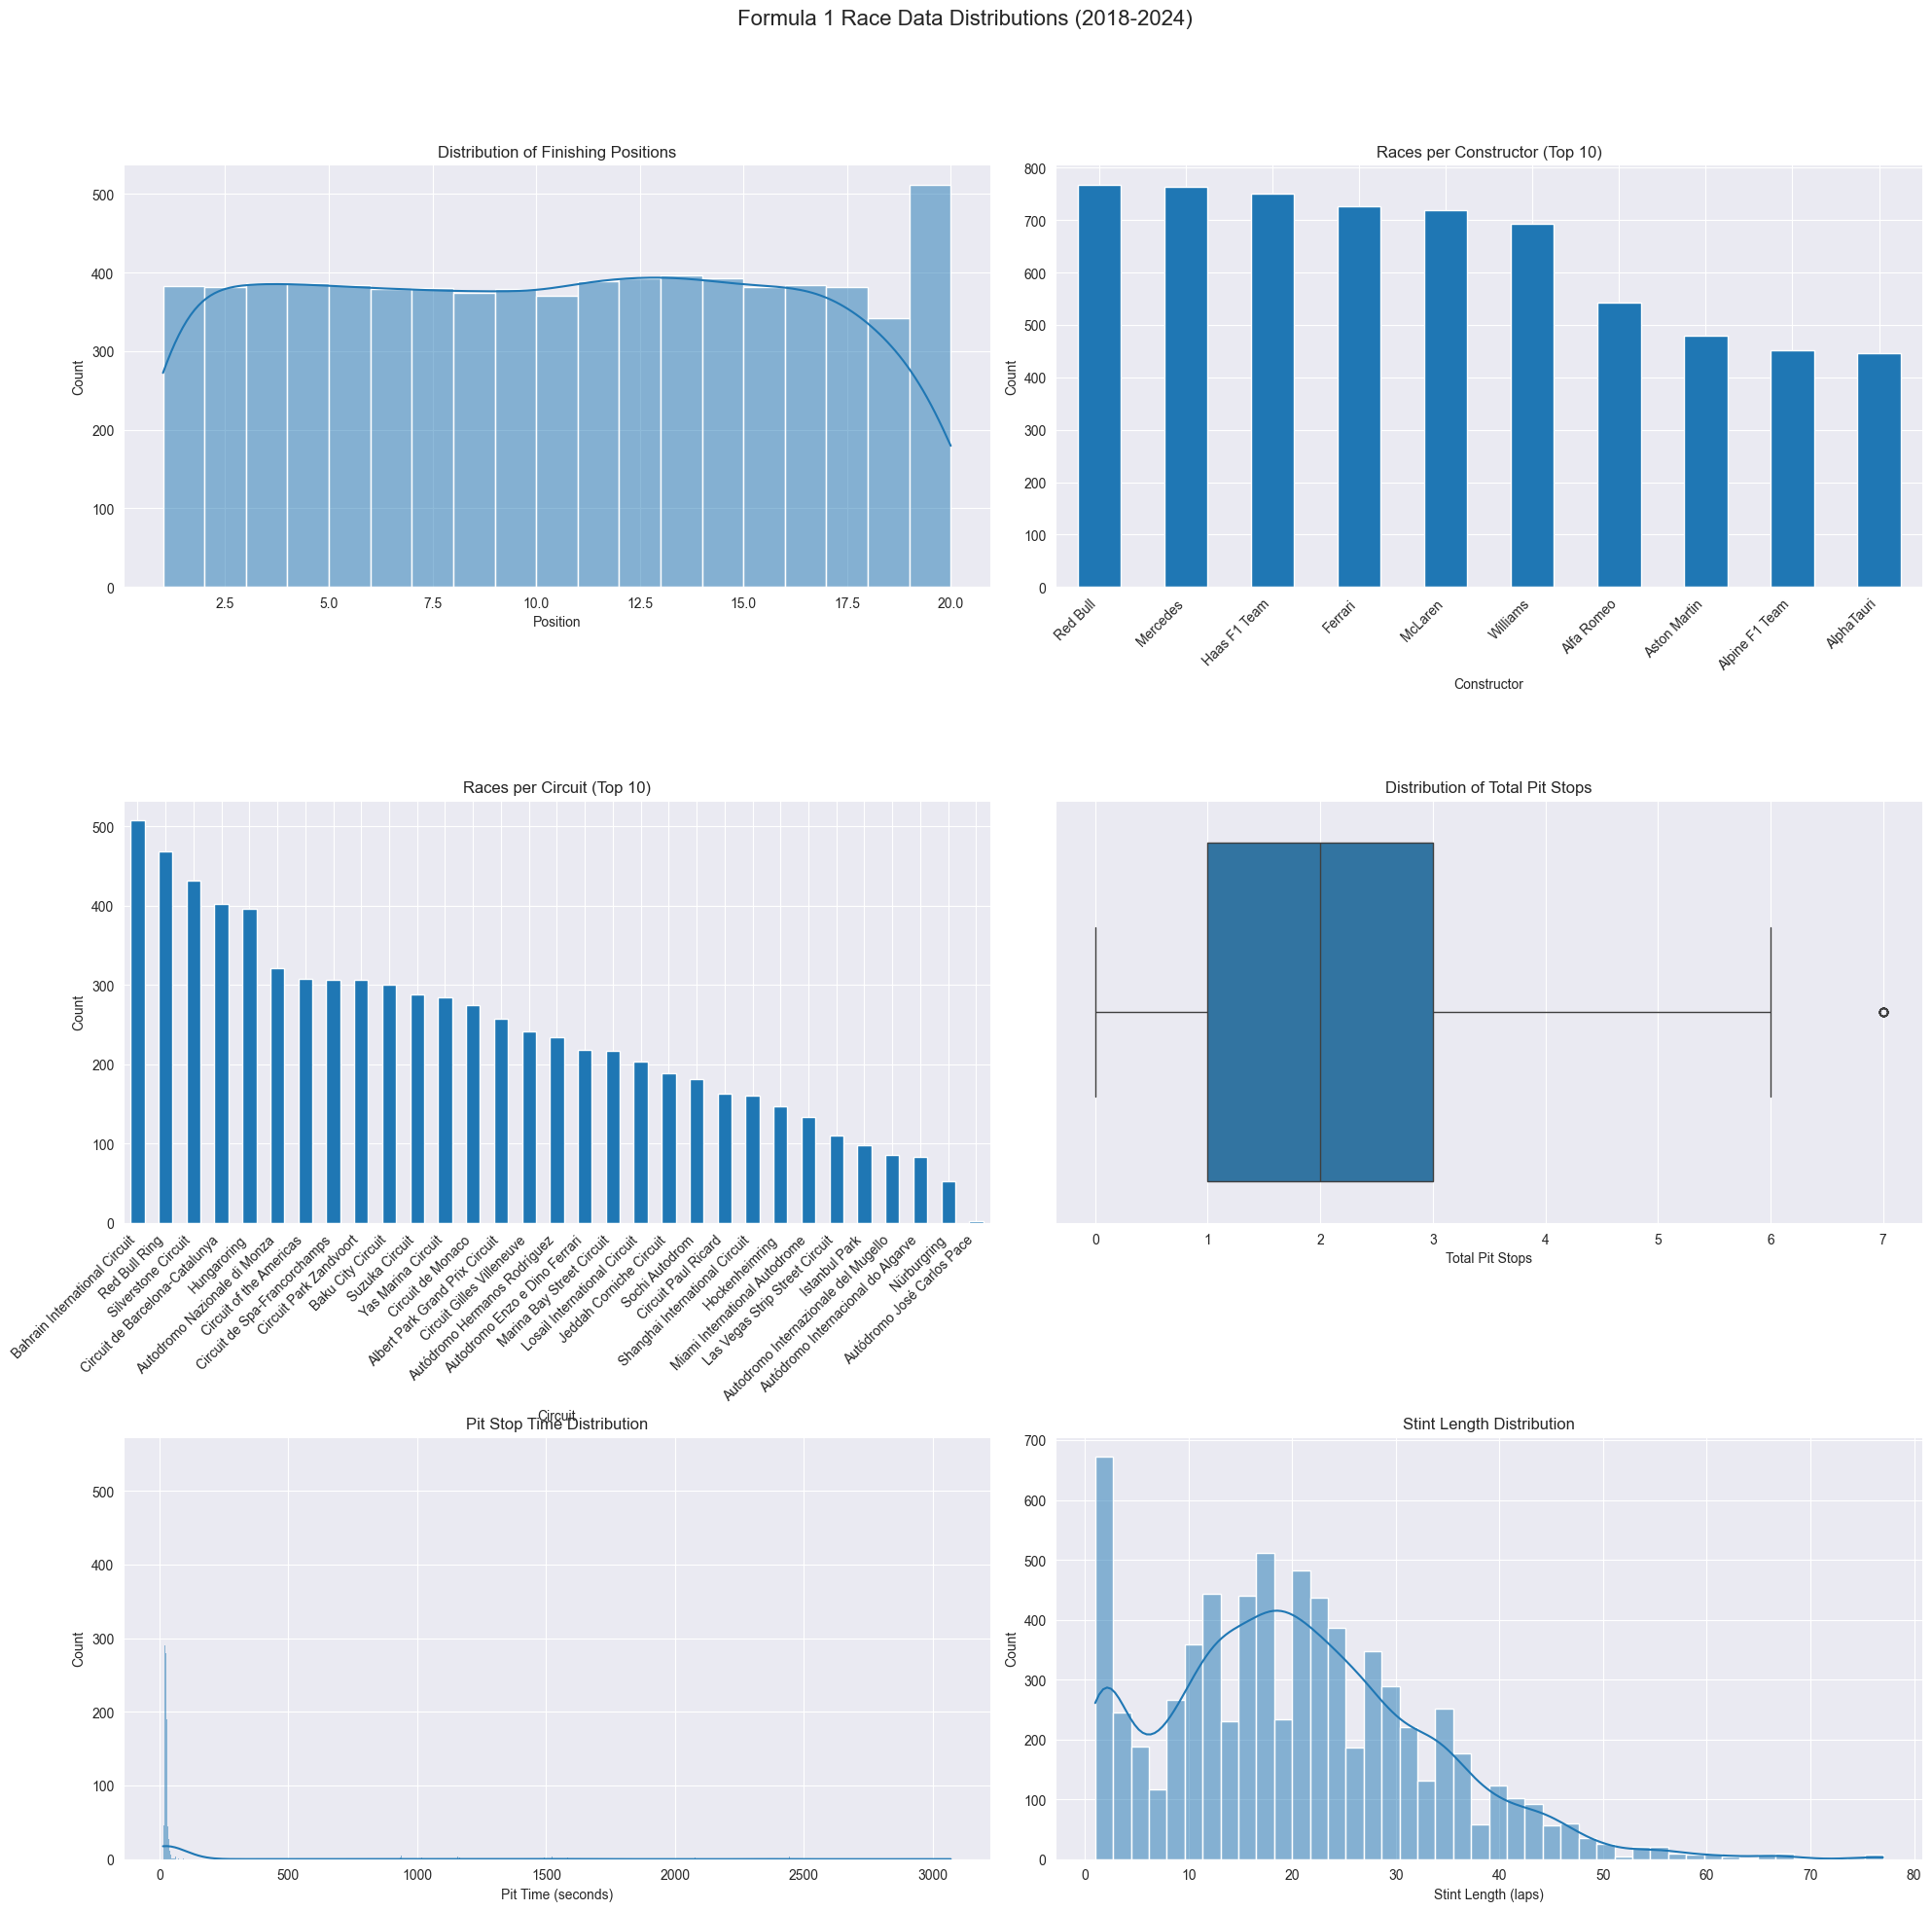

In [13]:
# Create a dashboard of key distributions
fig, axes = plt.subplots(3, 2, figsize=(20, 20))
axes = axes.flatten()

# 1. Distribution of finishing positions
sns.histplot(df['Position'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of Finishing Positions')
axes[0].set_xlabel('Position')

# 2. Races per constructor (top 10)
constructor_counts = df.groupby('Constructor').size().sort_values(ascending=False).head(10)
constructor_counts.plot(kind='bar', ax=axes[1])

axes[1].set_title('Races per Constructor (Top 10)')
axes[1].set_xlabel('Constructor')
axes[1].set_ylabel('Count')

plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')

# 3. Races per circuit (top 10)
circuit_counts = df.groupby('Circuit').size().sort_values(ascending=False)
circuit_counts.plot(kind='bar', ax=axes[2])

axes[2].set_title('Races per Circuit (Top 10)')
axes[2].set_xlabel('Circuit')
axes[2].set_ylabel('Count')

plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=45, ha='right')


# 4. Distribution of pit stops by driver
sns.boxplot(x='TotalPitStops', data=df, ax=axes[3])
axes[3].set_title('Distribution of Total Pit Stops')
axes[3].set_xlabel('Total Pit Stops')

# 5. Pit stop time distribution
pit_times = pd.to_numeric(df['Pit_Time'], errors='coerce')
pit_times = pit_times[pit_times > 0]  # Excluding 0 values (Final Stint)

sns.histplot(pit_times, kde=True, ax=axes[4])
axes[4].set_title('Pit Stop Time Distribution')
axes[4].set_xlabel('Pit Time (seconds)')


# 6. Distribution of stint lengths
sns.histplot(df['Stint Length'].dropna(), kde=True, ax=axes[5])
axes[5].set_title('Stint Length Distribution')
axes[5].set_xlabel('Stint Length (laps)')

plt.tight_layout()

plt.subplots_adjust(top=0.9)
plt.suptitle('Formula 1 Race Data Distributions (2018-2024)', fontsize=16)

plt.show()

* Apparently a significant part of the drivers finished in last posotion or, didn't finish at all (DNF)
* A few teams such as Alfa Romeo, Aston Martin, Alpine and Alpha Tauri don't have as many races because they're new teams, mostly from 2019 - 2021
* Some tracks almost never got raced on (Nurburgring... Istanbul Park) while on others, was a formality (Bahrain... Silverstone). However it's also concerning to know that the 
Autodromo Jose Carlos Pace has no Race count as it is one of the formalities to race on that is usually placed as the 3rd or 2nd to the last race of the calendar
* Stint lengths having values of 1-3 would probably be because of vehicle damage during an opening lap hence the driver pitting... Stints would normally be between the 19-25 lap
 mark

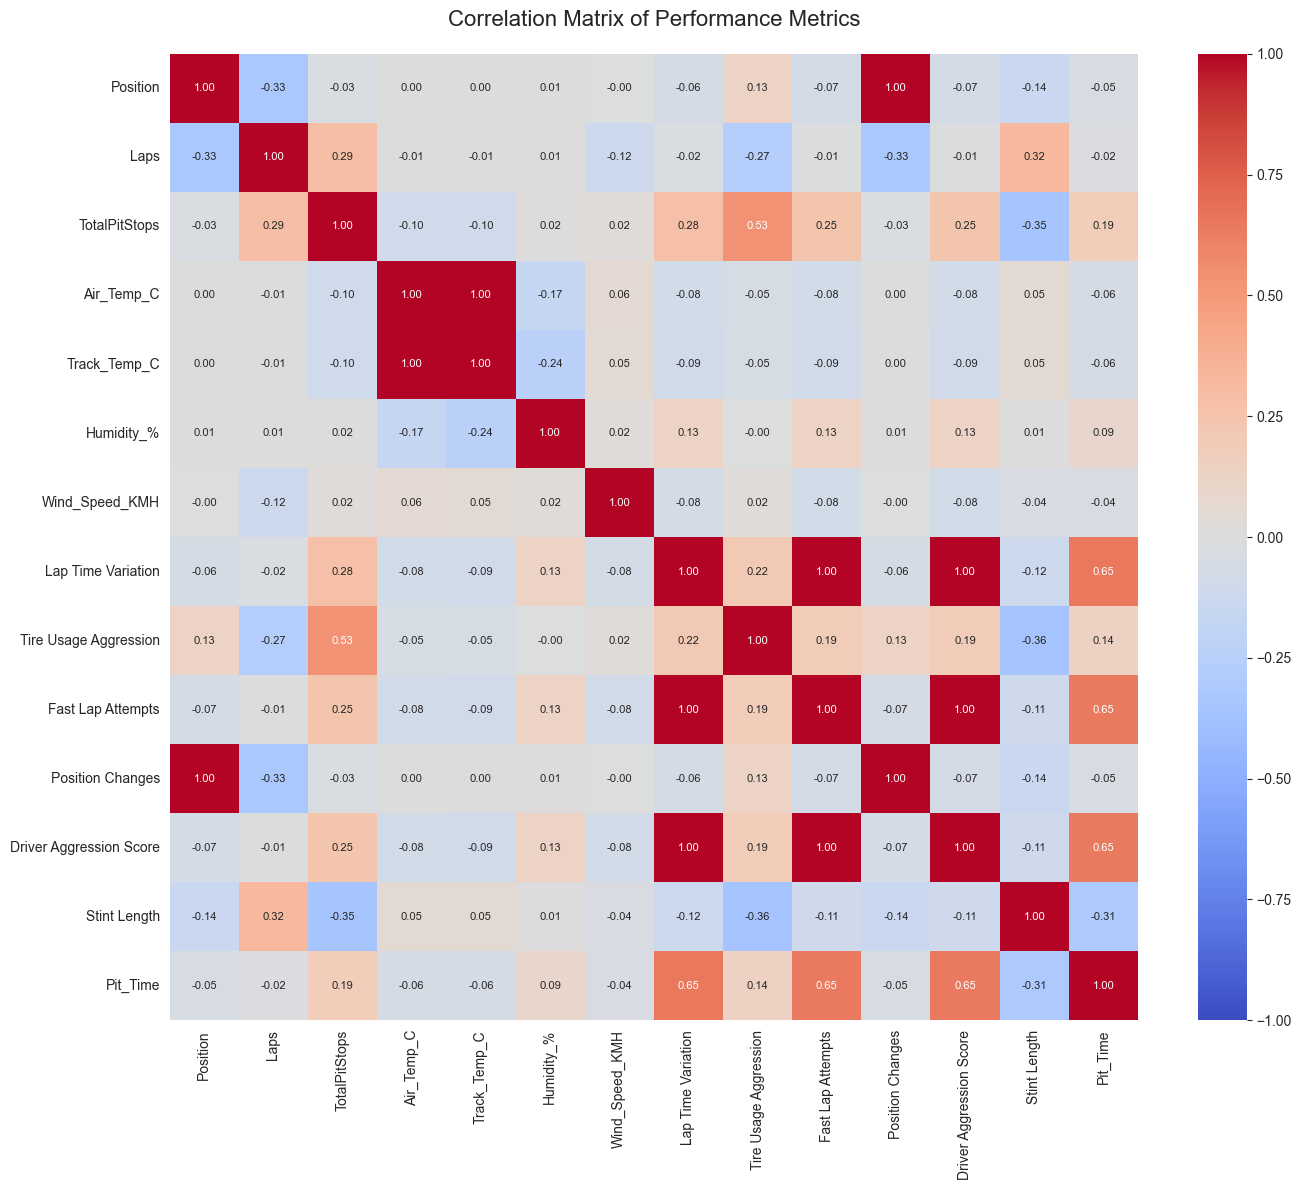

In [14]:
performance_vars = [
    'Position', 'Laps', 'TotalPitStops', 'Air_Temp_C', 'Track_Temp_C',
    'Humidity_%', 'Wind_Speed_KMH', 'Lap Time Variation', 'Tire Usage Aggression',
    'Fast Lap Attempts', 'Position Changes', 'Driver Aggression Score',
    'Stint Length', 'Pit_Time'
]

# Filter to include only columns that exist and convert to numeric
available_vars = [var for var in performance_vars if var in df.columns]
numeric_df = df[available_vars].apply(pd.to_numeric, errors='coerce')

# Calculate correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix))

sns.heatmap(
    corr_matrix, annot=True, cmap='coolwarm',
    vmin=-1, vmax=1, annot_kws={"size": 8}, fmt='.2f'
)

plt.title('Correlation Matrix of Performance Metrics', fontsize=16, pad=20)
plt.tight_layout()

plt.show()

### Few Key Takeaways
* Pit Times had a good correlation with the variation of lap times, fast lap attempts would increase because they would be pushing to catch up, meaning a higher aggression from 
the driver
* The more a driver pushes for a faster lap, it's said to influence their aggression score perfectly

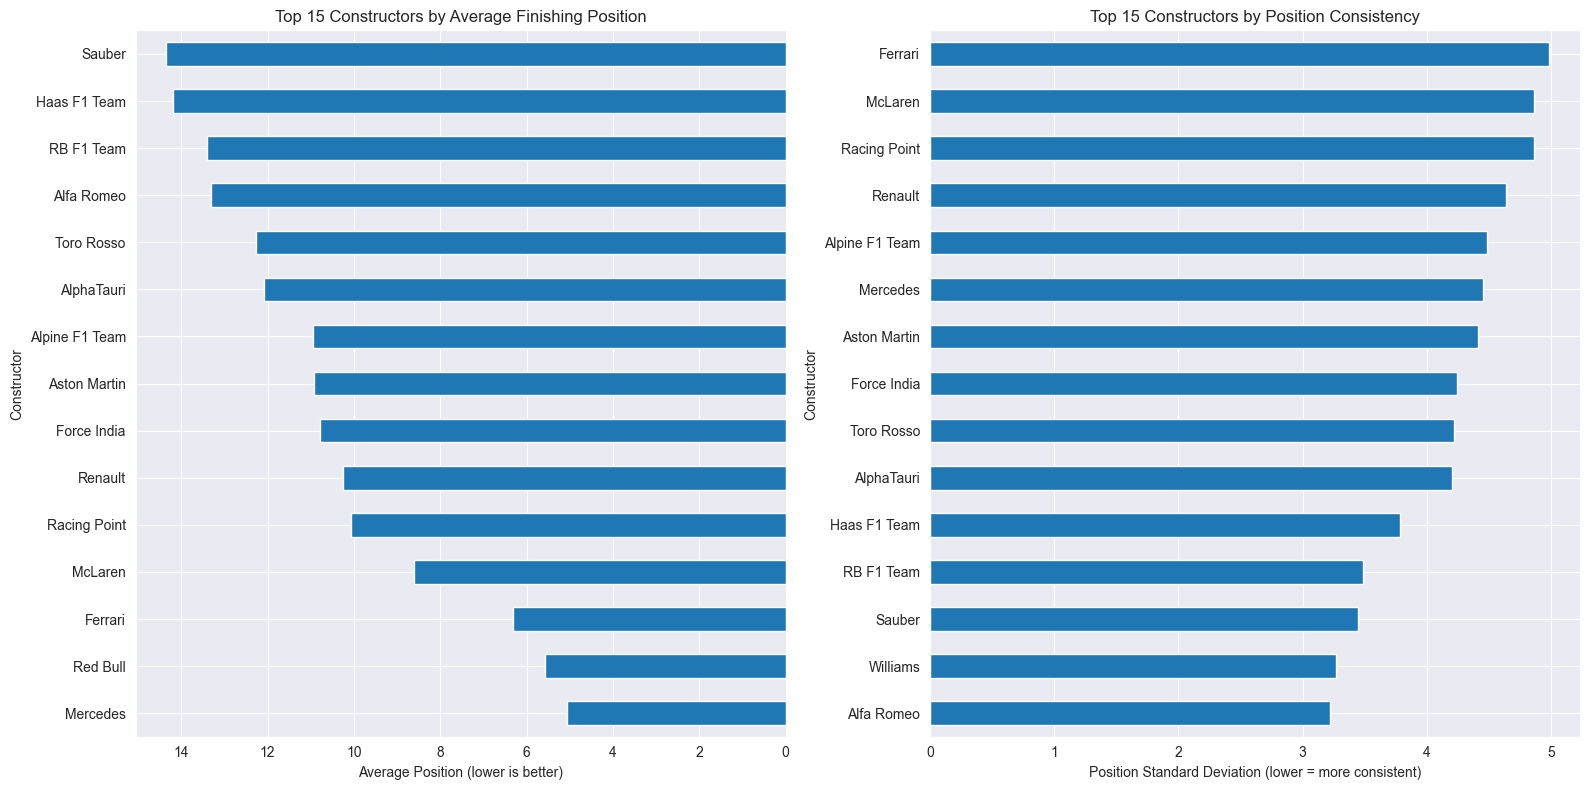

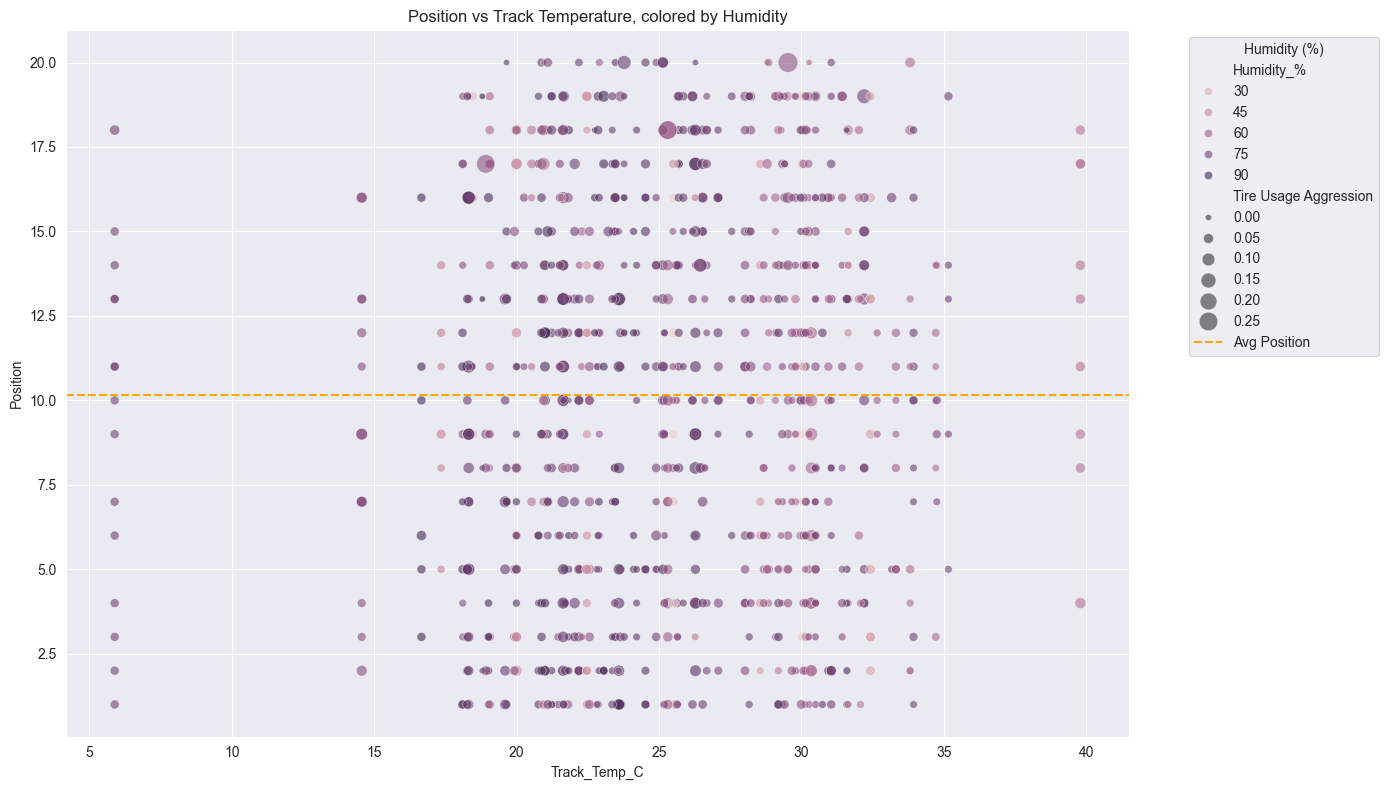

In [15]:
# Constructor performance visualization
plt.figure(figsize=(16, 8))

# 1. Average position by constructor
plt.subplot(1, 2, 1)
avg_pos_by_constructor = df.groupby('Constructor')['Position'].mean().sort_values()
avg_pos_by_constructor.head(15).plot(kind='barh')

plt.title('Top 15 Constructors by Average Finishing Position')
plt.xlabel('Average Position (lower is better)')

plt.gca().invert_xaxis()  # Invert x-axis so best teams are on top

# 2. Positional consistency by constructors
plt.subplot(1, 2, 2)
pos_std_by_constructor = df.groupby('Constructor')['Position'].std().sort_values()
pos_std_by_constructor.head(15).plot(kind='barh')

plt.title('Top 15 Constructors by Position Consistency')
plt.xlabel('Position Standard Deviation (lower = more consistent)')

plt.tight_layout()
plt.show()

# Circuit-specific performance analysis
plt.figure(figsize=(14, 8))

# Relationship between track characteristics and performance
sns.scatterplot(
    x='Track_Temp_C', y='Position', size='Tire Usage Aggression',
    hue='Humidity_%', data=df.sample(1000) if len(df) > 1000 else df,
    sizes=(20, 200), alpha=0.6
)

plt.title('Position vs Track Temperature, colored by Humidity')
plt.axhline(y=df['Position'].mean(), color='orange', linestyle='--', label='Avg Position')
plt.legend(title='Humidity (%)', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

* The first two plots clearly show how much having a good team and a good car counts for having a good finishing position
* The horizontal bar plot on the left shows how important it probably is acclamtise the car to a track in order to keep a consistent car all year round

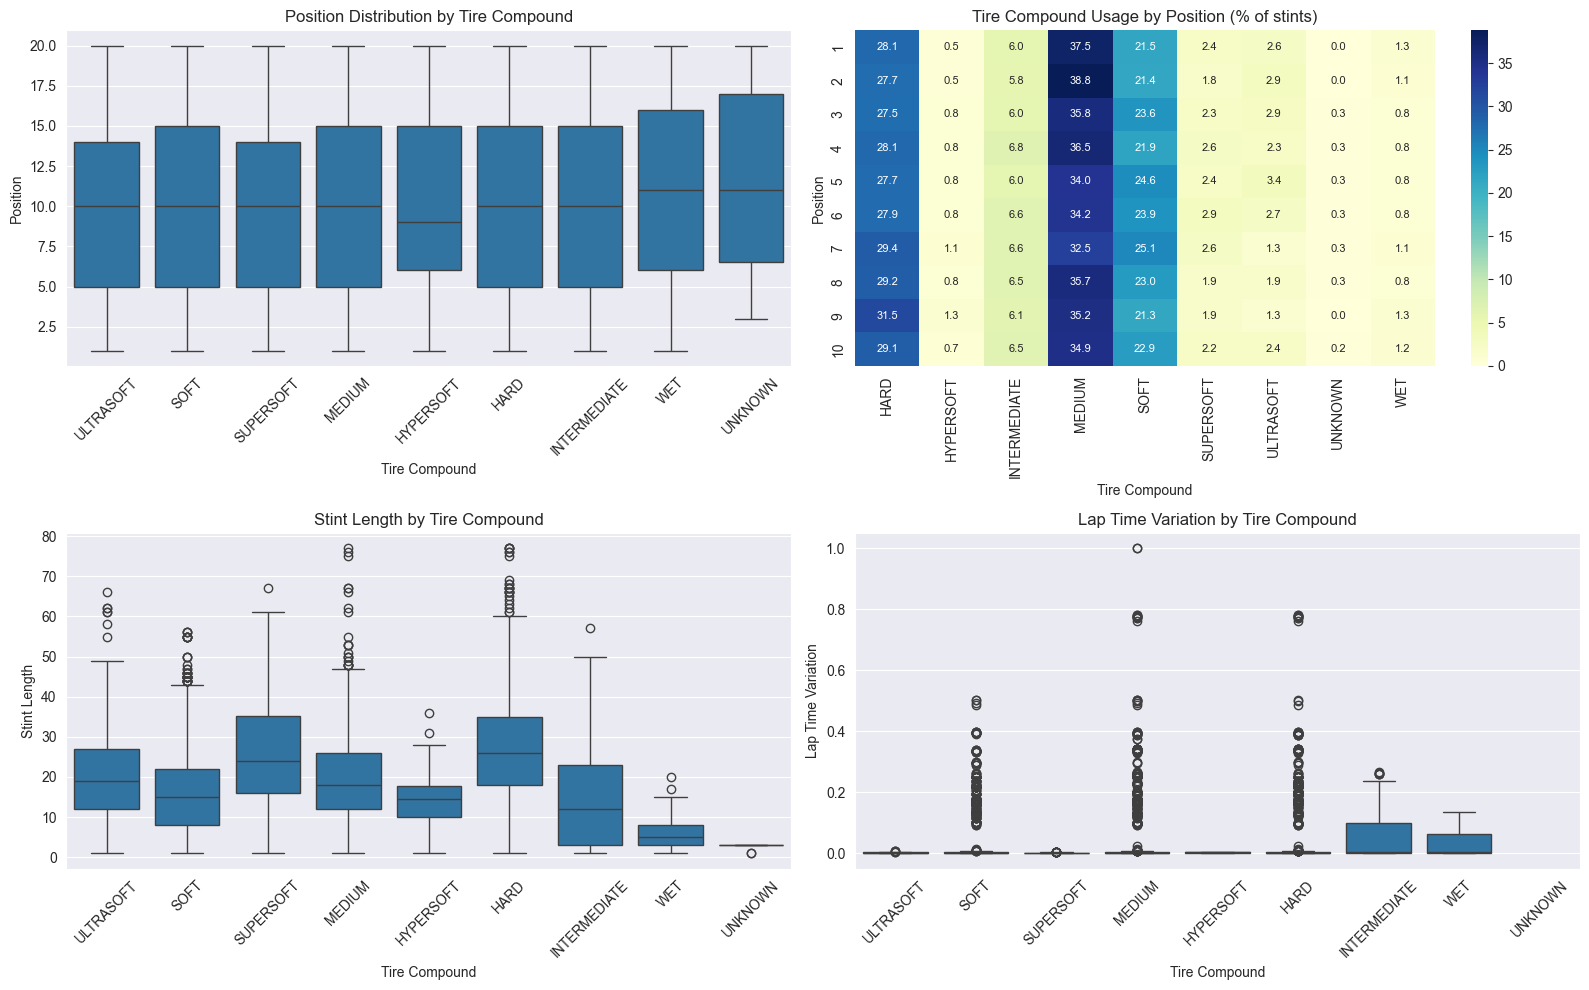

In [16]:
if 'Tire Compound' in df.columns:
    plt.figure(figsize=(16, 10))

    # 1. Position by tire compound
    plt.subplot(2, 2, 1)
    sns.boxplot(x='Tire Compound', y='Position', data=df)
    plt.title('Position Distribution by Tire Compound')
    plt.xticks(rotation=45)

    # 2. Tire usage by position
    plt.subplot(2, 2, 2)
    tire_pos_counts = pd.crosstab(df['Position'].apply(lambda x: min(x, 10)), df['Tire Compound'], normalize='index') * 100

    sns.heatmap( tire_pos_counts, annot=True, cmap='YlGnBu', fmt='.1f', annot_kws={ "size": 8 })
    plt.title('Tire Compound Usage by Position (% of stints)')

    # 3. Stint length by compound
    plt.subplot(2, 2, 3)
    sns.boxplot(x='Tire Compound', y='Stint Length', data=df)
    plt.title('Stint Length by Tire Compound')
    plt.xticks(rotation=45)

    # 4. Lap time variation by compound 
    plt.subplot(2, 2, 4)
    sns.boxplot(x='Tire Compound', y='Lap Time Variation', data=df)
    plt.title('Lap Time Variation by Tire Compound')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()


* Your finishing tire will almost not matter as the strategy is responsible for your finishing positon and the weather and track conditions as well
* The SOFT, MEDIUM and HARD tyres will be mostly referenced as they became the new norm as of 2019
* This is confirmed by the CrossTab plot to right - Mediums were often the tyre of choice due to its flexibility, with Hards and Soft giving you longevity or grip as needed 
respectively

* Ultra-Softs and Super-Softs were surprisingly used on stints longer than they would serve.
* It only made sense to use Softs, Mediums and Hards each on longer stints with Softs being used the shortest.
* Lap Time Variations only had a significance while using Intermediates and Wets, drivers would have to tread carefully with little or no grip.

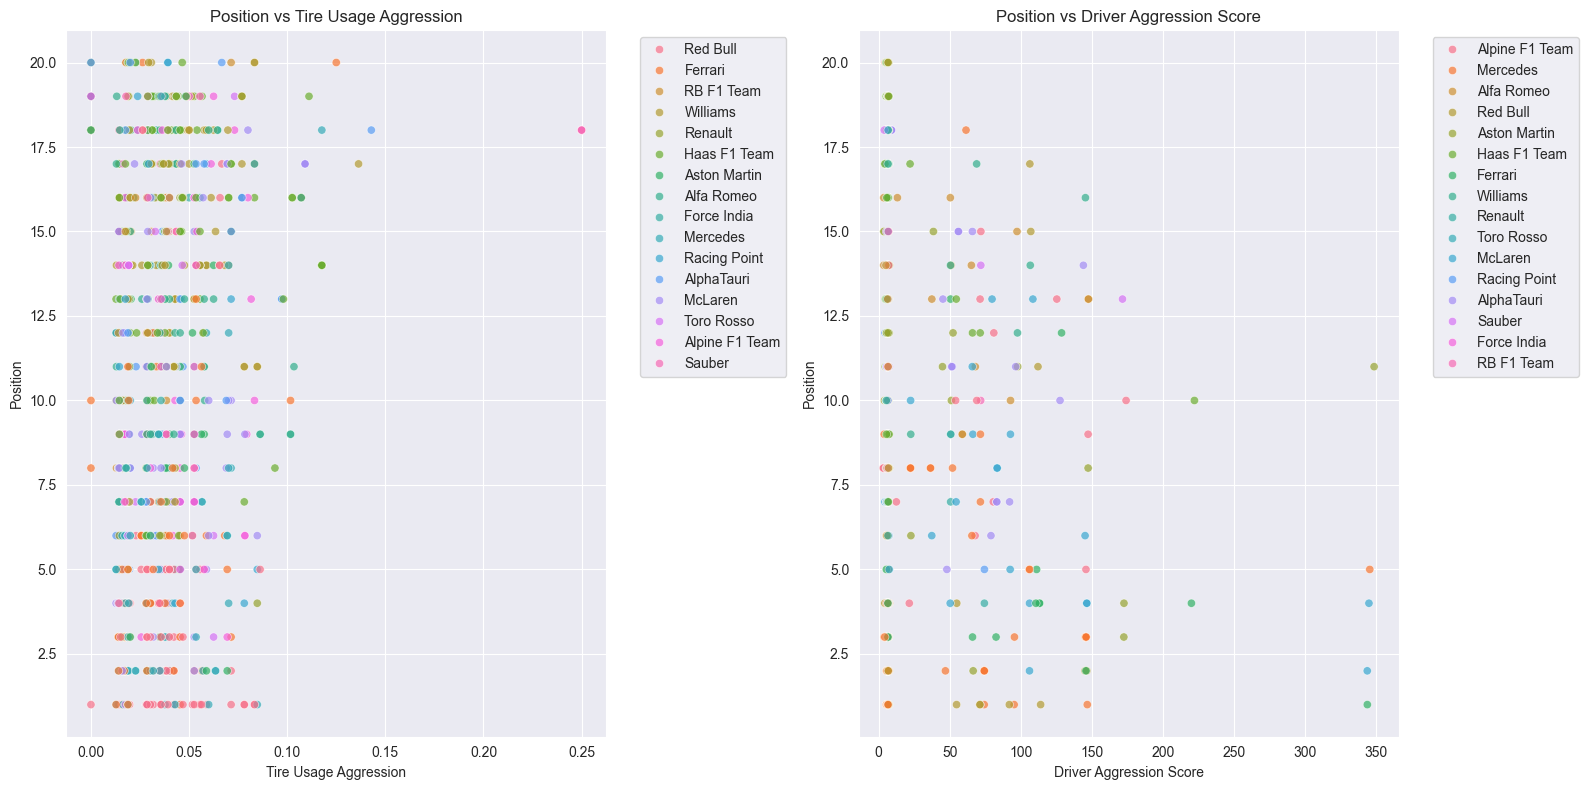

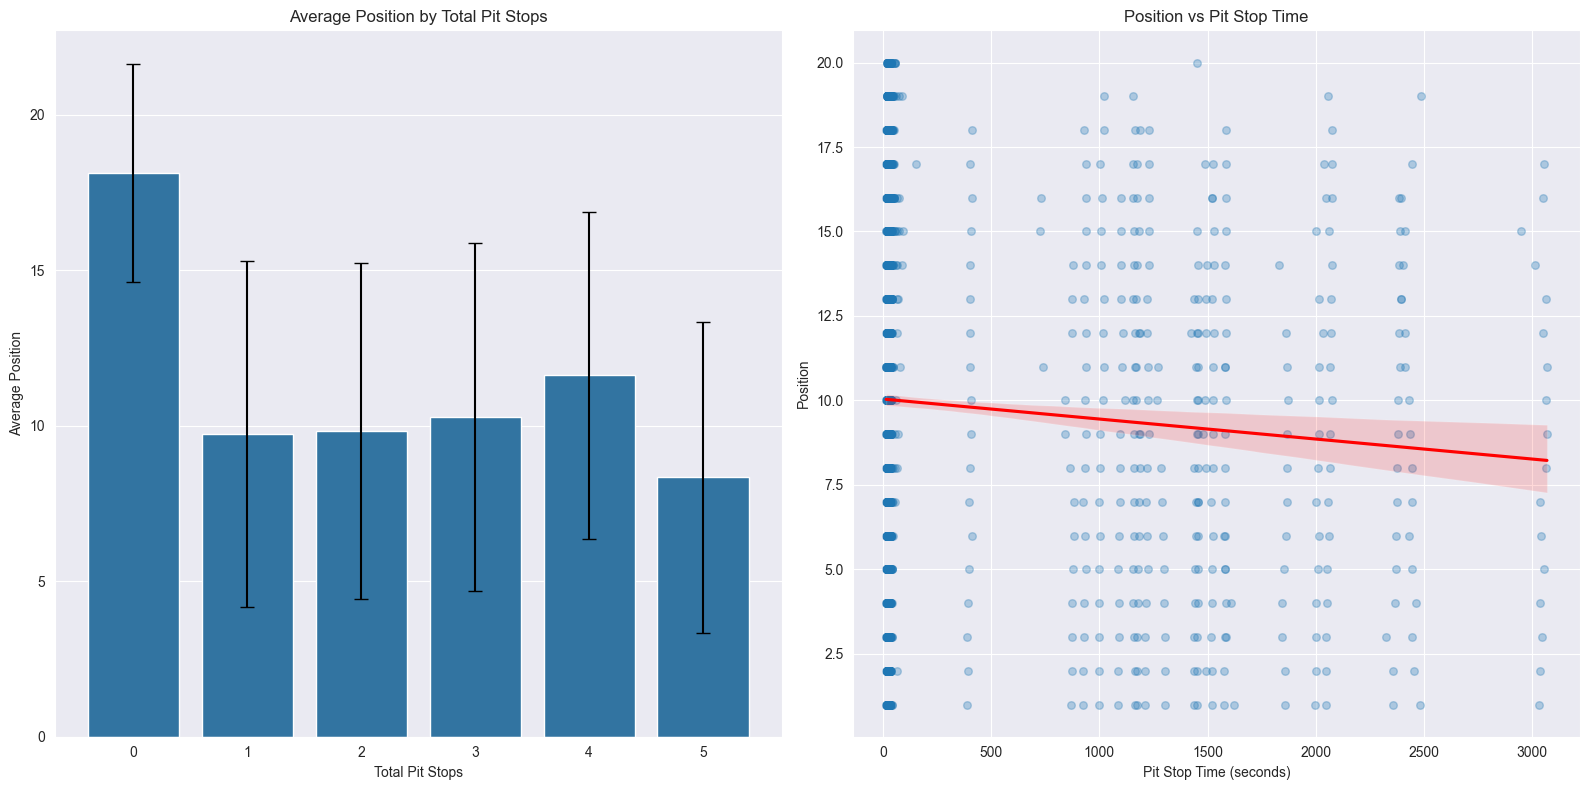

In [17]:
# Driver aggression and race performance
plt.figure(figsize=(16, 8))

# 1. Tire usage aggression vs position
plt.subplot(1, 2, 1)
sns.scatterplot( x='Tire Usage Aggression', y='Position', hue='Constructor', data=df.sample(min(1000, len(df))), alpha=0.7)
plt.title('Position vs Tire Usage Aggression')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 2. Driver aggression vs position
plt.subplot(1, 2, 2)
sns.scatterplot( x='Driver Aggression Score', y='Position', hue='Constructor', data=df.sample(min(1000, len(df))), alpha=0.7)
plt.title('Position vs Driver Aggression Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Pit stop strategy analysis
plt.figure(figsize=(16, 8))

# 1. Total pit stops vs position
plt.subplot(1, 2, 1)
pit_pos_data = df.groupby('TotalPitStops')['Position'].agg(['mean', 'std']).reset_index()
pit_pos_data = pit_pos_data[pit_pos_data['TotalPitStops'] <= 5]  # Filter out extreme values

sns.barplot(x='TotalPitStops', y='mean', data=pit_pos_data)
plt.errorbar( x=pit_pos_data.index, y=pit_pos_data['mean'], yerr=pit_pos_data['std'], fmt='none', color='black', capsize=5)
plt.title('Average Position by Total Pit Stops')
plt.xlabel('Total Pit Stops')
plt.ylabel('Average Position')

# 2. Pit time vs position
plt.subplot(1, 2, 2)
pit_time_numeric = pd.to_numeric(df['Pit_Time'], errors='coerce')
# Filter out "Final Stint" values (converted to 0)
pit_time_data = df[pit_time_numeric > 0].copy()
pit_time_data['Pit_Time_Numeric'] = pit_time_numeric[pit_time_numeric > 0]

sns.regplot( x='Pit_Time_Numeric', y='Position', data=pit_time_data, scatter_kws={'alpha': 0.3, 's': 30}, line_kws={ 'color': 'red' })
plt.title('Position vs Pit Stop Time')
plt.xlabel('Pit Stop Time (seconds)')
plt.ylabel('Position')

plt.tight_layout()
plt.show()

In [18]:
# 1. Handle Stint-related missing values (109 missing values each)

# 1.1 Identify final stints
df['Max_Stint'] = df.groupby(['Season', 'Round', 'Driver'])['Stint'].transform('max')
df['Is_Final_Stint'] = (df['Stint'] == df['Max_Stint'])
df['Is_Final_Stint']

0       False
1        True
2       False
3        True
4       False
        ...  
7369    False
7370     True
7371    False
7372     True
7373     True
Name: Is_Final_Stint, Length: 7374, dtype: bool

In [19]:
# 1.2 For missing Stint data (DNF entries)
missing_stint_mask = df['Stint'].isna()
if missing_stint_mask.sum() > 0:
    # Set Stint to 1 (first and only stint for DNF)
    df.loc[missing_stint_mask, 'Stint'] = 1

    # Set Max_Stint to 1 (only one stint for DNF)
    df.loc[missing_stint_mask, 'Max_Stint'] = 1

    # Set Stint Length to equal laps completed
    df.loc[missing_stint_mask, 'Stint Length'] = df.loc[missing_stint_mask, 'Laps']

    # Set Pit_Lap to final lap completed
    df.loc[missing_stint_mask, 'Pit_Lap'] = df.loc[missing_stint_mask, 'Laps']

    # Calculate race completion percentage
    max_race_laps = df.groupby(['Season', 'Round'])['Laps'].transform('max')
    df['Race_Completion_Pct'] = (df['Laps'] / max_race_laps * 100).round(1)

    print(f"Imputed {missing_stint_mask.sum()} DNF/partial race entries with single stint data")

df['Race_Completion_Pct']

Imputed 109 DNF/partial race entries with single stint data


0       100.0
1       100.0
2       100.0
3       100.0
4       100.0
        ...  
7369     51.7
7370     51.7
7371     44.8
7372     44.8
7373      0.0
Name: Race_Completion_Pct, Length: 7374, dtype: float64

In [20]:
# Convert 'Final Stint' string values to numeric 0
final_stint_mask = df['Pit_Time'] == 'Final Stint'

df['Pit_Time_Numeric'] = pd.to_numeric(df['Pit_Time'], errors='coerce')
df.loc[final_stint_mask, 'Pit_Time_Numeric'] = 0

In [21]:
# For final stints with missing pit time, set to 0
final_stint_missing_mask = df['Is_Final_Stint'] & df['Pit_Time_Numeric'].isna()
df.loc[final_stint_missing_mask, 'Pit_Time_Numeric'] = 0

In [22]:
non_final_missing_mask = (~df['Is_Final_Stint']) & df['Pit_Time_Numeric'].isna()

In [23]:
for idx in df[non_final_missing_mask].index:
    constructor = df.loc[idx, 'Constructor']
    circuit = df.loc[idx, 'Circuit']

    # Try team-circuit median
    team_circuit_median = df[(df['Constructor'] == constructor) &
                             (df['Circuit'] == circuit) &
                             (~final_stint_mask) &
                             df['Pit_Time_Numeric'].notna()]['Pit_Time_Numeric'].median()

    if not pd.isna(team_circuit_median):
        df.loc[idx, 'Pit_Time_Numeric'] = team_circuit_median
    else:
        # Try team median
        team_median = df[(df['Constructor'] == constructor) &
                         (~final_stint_mask) &
                         df['Pit_Time_Numeric'].notna()]['Pit_Time_Numeric'].median()

        if not pd.isna(team_median):
            df.loc[idx, 'Pit_Time_Numeric'] = team_median
        else:
            # Use overall median
            overall_median = df[~final_stint_mask & df['Pit_Time_Numeric'].notna()]['Pit_Time_Numeric'].median()
            df.loc[idx, 'Pit_Time_Numeric'] = overall_median

# Replace original Pit_Time with numeric version
df['Pit_Time'] = df['Pit_Time_Numeric']
df.drop('Pit_Time_Numeric', axis=1, inplace=True)

In [24]:
for idx in df[df['Tire Compound'].isna()].index:
    season = df.loc[idx, 'Season']
    round_num = df.loc[idx, 'Round']
    stint_num = df.loc[idx, 'Stint']

    # For starting stint, use most common starter for that race
    if stint_num == 1:
        most_common = df[(df['Season'] == season) &
                         (df['Round'] == round_num) &
                         (df['Stint'] == 1) &
                         df['Tire Compound'].notna()]['Tire Compound'].mode()

        if not most_common.empty:
            df.loc[idx, 'Tire Compound'] = most_common[0]
            continue

    # For final stint, use most common finisher
    if df.loc[idx, 'Stint'] == df.loc[idx, 'Max_Stint']:
        most_common = df[(df['Season'] == season) &
                         (df['Round'] == round_num) &
                         (df['Stint'] == df['Max_Stint']) &
                         df['Tire Compound'].notna()]['Tire Compound'].mode()

        if not most_common.empty:
            df.loc[idx, 'Tire Compound'] = most_common[0]
            continue

    # For middle stints, use most common for that stint number
    most_common = df[(df['Season'] == season) &
                     (df['Round'] == round_num) &
                     (df['Stint'] == stint_num) &
                     df['Tire Compound'].notna()]['Tire Compound'].mode()

    if not most_common.empty:
        df.loc[idx, 'Tire Compound'] = most_common[0]
        continue

    # Fallback: Use most common compound for the race
    race_common = df[(df['Season'] == season) &
                     (df['Round'] == round_num) &
                     df['Tire Compound'].notna()]['Tire Compound'].mode()

    if not race_common.empty:
        df.loc[idx, 'Tire Compound'] = race_common[0]
    else:
        # Final fallback: Use SOFT as default
        df.loc[idx, 'Tire Compound'] = "SOFT"

# 4. Handle Driver Performance Metrics
print("Handling Driver Performance Metrics...")

Handling Driver Performance Metrics...


In [25]:
for idx in df[df['Tire Usage Aggression'].isna()].index:
    driver = df.loc[idx, 'Driver']
    
    if not pd.isna(df.loc[idx, 'Tire Compound']):
        compound = df.loc[idx, 'Tire Compound']

        # Driver's average with this compound
        driver_compound_avg = df[(df['Driver'] == driver) &
                                 (df['Tire Compound'] == compound) &
                                 df['Tire Usage Aggression'].notna()]['Tire Usage Aggression'].mean()

        if not pd.isna(driver_compound_avg):
            df.loc[idx, 'Tire Usage Aggression'] = driver_compound_avg
            continue

    # Driver's overall average
    driver_avg = df[(df['Driver'] == driver) &
                    df['Tire Usage Aggression'].notna()]['Tire Usage Aggression'].mean()

    if not pd.isna(driver_avg):
        df.loc[idx, 'Tire Usage Aggression'] = driver_avg
        continue

    # Constructor average
    constructor = df.loc[idx, 'Constructor']
    team_avg = df[(df['Constructor'] == constructor) &
                  df['Tire Usage Aggression'].notna()]['Tire Usage Aggression'].mean()

    if not pd.isna(team_avg):
        df.loc[idx, 'Tire Usage Aggression'] = team_avg
        continue

    # Global average
    df.loc[idx, 'Tire Usage Aggression'] = df['Tire Usage Aggression'].mean()

In [26]:
# 4.2 Fast Lap Attempts and Driver Aggression Score (185 missing each)
for metric in ['Fast Lap Attempts', 'Driver Aggression Score']:
    for idx in df[df[metric].isna()].index:
        driver = df.loc[idx, 'Driver']
        position = df.loc[idx, 'Position']

        # Similar positions (±2)
        similar_positions = range(max(1, position-2), position+3)
        driver_position_avg = df[(df['Driver'] == driver) &
                                 df['Position'].isin(similar_positions) &
                                 df[metric].notna()][metric].mean()

        if not pd.isna(driver_position_avg):
            df.loc[idx, metric] = driver_position_avg
            continue

        # Driver's overall average
        driver_avg = df[(df['Driver'] == driver) & df[metric].notna()][metric].mean()

        if not pd.isna(driver_avg):
            df.loc[idx, metric] = driver_avg
            continue

        # Position-based average
        position_avg = df[df['Position'] == position & df[metric].notna()][metric].mean()

        if not pd.isna(position_avg):
            df.loc[idx, metric] = position_avg
            continue

        # Global average
        df.loc[idx, metric] = df[metric].mean()

In [27]:
print("Handling Lap Time Variation...")

for idx in df[df['Lap Time Variation'].isna()].index:
    driver = df.loc[idx, 'Driver']
    circuit = df.loc[idx, 'Circuit']
    season = df.loc[idx, 'Season']

    # Driver-circuit-season specific median
    driver_circuit_season_median = df[(df['Driver'] == driver) &
                                      (df['Circuit'] == circuit) &
                                      (df['Season'] == season) &
                                      df['Lap Time Variation'].notna()]['Lap Time Variation'].median()

    if not pd.isna(driver_circuit_season_median):
        df.loc[idx, 'Lap Time Variation'] = driver_circuit_season_median
        continue

    # Driver-circuit specific median
    driver_circuit_median = df[(df['Driver'] == driver) &
                               (df['Circuit'] == circuit) &
                               df['Lap Time Variation'].notna()]['Lap Time Variation'].median()

    if not pd.isna(driver_circuit_median):
        df.loc[idx, 'Lap Time Variation'] = driver_circuit_median
        continue

    # Driver-team-season specific median
    constructor = df.loc[idx, 'Constructor']
    driver_team_season_median = df[(df['Driver'] == driver) &
                                   (df['Constructor'] == constructor) &
                                   (df['Season'] == season) &
                                   df['Lap Time Variation'].notna()]['Lap Time Variation'].median()

    if not pd.isna(driver_team_season_median):
        df.loc[idx, 'Lap Time Variation'] = driver_team_season_median
        continue

    # Circuit-position specific median
    position = df.loc[idx, 'Position']
    circuit_position_median = df[(df['Circuit'] == circuit) &
                                 (df['Position'] == position) &
                                 df['Lap Time Variation'].notna()]['Lap Time Variation'].median()

    if not pd.isna(circuit_position_median):
        df.loc[idx, 'Lap Time Variation'] = circuit_position_median
        continue

    # Progressively widening search until we find a value
    for search_method in [
        # Team performance at this circuit
        lambda: df[(df['Constructor'] == constructor) &
                   (df['Circuit'] == circuit) &
                   df['Lap Time Variation'].notna()]['Lap Time Variation'].median(),

        # Driver median across all circuits
        lambda: df[(df['Driver'] == driver) &
                   df['Lap Time Variation'].notna()]['Lap Time Variation'].median(),

        # Circuit median across all drivers
        lambda: df[(df['Circuit'] == circuit) &
                   df['Lap Time Variation'].notna()]['Lap Time Variation'].median(),

        # Position-based median
        lambda: df[(df['Position'] == position) &
                   df['Lap Time Variation'].notna()]['Lap Time Variation'].median(),

        # Constructor median
        lambda: df[(df['Constructor'] == constructor) &
                   df['Lap Time Variation'].notna()]['Lap Time Variation'].median(),

        # Global median (final fallback)
        lambda: df['Lap Time Variation'].median()
    ]:
        result = search_method()
        if not pd.isna(result):
            df.loc[idx, 'Lap Time Variation'] = result
            break


Handling Lap Time Variation...


In [28]:
print("Handling location metadata...")

categorical_cols = ['Time_of_race', 'Location', 'Country']

for col in categorical_cols:
    # Circuit-based mode
    circuit_mode = {}
    
    for circuit in df['Circuit'].unique():
        circuit_data = df[df['Circuit'] == circuit][col]
        if not circuit_data.empty and not circuit_data.dropna().empty:
            circuit_mode[circuit] = circuit_data.mode()[0]

    # Apply mapping
    for circuit, mode_value in circuit_mode.items():
        mask = (df['Circuit'] == circuit) & (df[col].isna())
        df.loc[mask, col] = mode_value

    # Final global mode fallback
    if df[col].isna().sum() > 0:
        df[col] = df[col].fillna(df[col].mode()[0])

Handling location metadata...


In [29]:
print("Handling weather data...")

weather_cols = ['Air_Temp_C', 'Track_Temp_C', 'Humidity_%', 'Wind_Speed_KMH']
for col in weather_cols:
    # Circuit mean
    circuit_mean = {}
    for circuit in df['Circuit'].unique():
        circuit_data = df[df['Circuit'] == circuit][col]
        if not circuit_data.empty and not circuit_data.dropna().empty:
            circuit_mean[circuit] = circuit_data.mean()

    # Apply mapping
    for circuit, mean_value in circuit_mean.items():
        mask = (df['Circuit'] == circuit) & (df[col].isna())
        df.loc[mask, col] = mean_value

    # Season-month patterns
    if df[col].isna().sum() > 0 and 'Date' in df.columns:
        df['Month'] = pd.to_datetime(df['Date']).dt.month
        for month in df['Month'].unique():
            month_median = df[df['Month'] == month][col].median()
            mask = (df['Month'] == month) & (df[col].isna())
            df.loc[mask, col] = month_median
            
        df.drop('Month', axis=1, inplace=True)

    # Global median fallback
    if df[col].isna().sum() > 0:
        df[col] = df[col].fillna(df[col].median())

Handling weather data...


In [30]:
print(df.isna().sum())

Season                        0
Round                         0
Circuit                       0
Driver                        0
Constructor                   0
Laps                          0
Position                      0
TotalPitStops                 0
AvgPitStopTime              185
Race Name                   373
Date                        373
Time_of_race                  0
Location                      0
Country                       0
Air_Temp_C                    0
Track_Temp_C                  0
Humidity_%                    0
Wind_Speed_KMH                0
Lap Time Variation            0
Total Pit Stops               0
Tire Usage Aggression         0
Fast Lap Attempts             0
Position Changes              0
Driver Aggression Score       0
Abbreviation                  0
Stint                         0
Tire Compound                 0
Stint Length                  0
Pit_Lap                    2701
Pit_Time                      0
Max_Stint                     0
Is_Final

In [31]:
# Final check for missing values
remaining_missing = df.isna().sum()
print("\nRemaining missing values after imputation:")
print(remaining_missing[remaining_missing > 0])


Remaining missing values after imputation:
AvgPitStopTime     185
Race Name          373
Date               373
Pit_Lap           2701
dtype: int64


In [32]:
df

,Season,Round,Circuit,Driver,Constructor,Laps,Position,TotalPitStops,AvgPitStopTime,Race Name,...,Driver Aggression Score,Abbreviation,Stint,Tire Compound,Stint Length,Pit_Lap,Pit_Time,Max_Stint,Is_Final_Stint,Race_Completion_Pct
0,2018,1,Albert Park Grand Prix Circuit,Sebastian Vettel,Ferrari,58,1,1,21.787,Australian Grand Prix,...,6.755003,VET,1.0,ULTRASOFT,25.0,26.0,21.787,2.0,False,100.0
1,2018,1,Albert Park Grand Prix Circuit,Sebastian Vettel,Ferrari,58,1,1,21.787,Australian Grand Prix,...,6.755003,VET,2.0,SOFT,32.0,NaN,0.000,2.0,True,100.0
2,2018,1,Albert Park Grand Prix Circuit,Lewis Hamilton,Mercedes,58,2,1,21.821,Australian Grand Prix,...,6.754254,HAM,1.0,ULTRASOFT,17.0,19.0,21.821,2.0,False,100.0
3,2018,1,Albert Park Grand Prix Circuit,Lewis Hamilton,Mercedes,58,2,1,21.821,Australian Grand Prix,...,6.754254,HAM,2.0,SOFT,39.0,NaN,0.000,2.0,True,100.0
4,2018,1,Albert Park Grand Prix Circuit,Kimi Räikkönen,Ferrari,58,3,1,21.421,Australian Grand Prix,...,6.818562,RAI,1.0,ULTRASOFT,17.0,18.0,21.421,2.0,False,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7369,2024,24,Yas Marina Circuit,Valtteri Bottas,Sauber,30,18,1,41.144,Abu Dhabi Grand Prix,...,3.930495,BOT,1.0,MEDIUM,6.0,6.0,41.144,2.0,False,51.7
7370,2024,24,Yas Marina Circuit,Valtteri Bottas,Sauber,30,18,1,41.144,Abu Dhabi Grand Prix,...,3.930495,BOT,2.0,HARD,24.0,NaN,0.000,2.0,True,51.7
7371,2024,24,Yas Marina Circuit,Franco Colapinto,Williams,26,19,1,24.941,Abu Dhabi Grand Prix,...,6.364719,COL,1.0,MEDIUM,3.0,3.0,24.941,2.0,False,44.8
7372,2024,24,Yas Marina Circuit,Franco Colapinto,Williams,26,19,1,24.941,Abu Dhabi Grand Prix,...,6.364719,COL,2.0,HARD,23.0,NaN,0.000,2.0,True,44.8


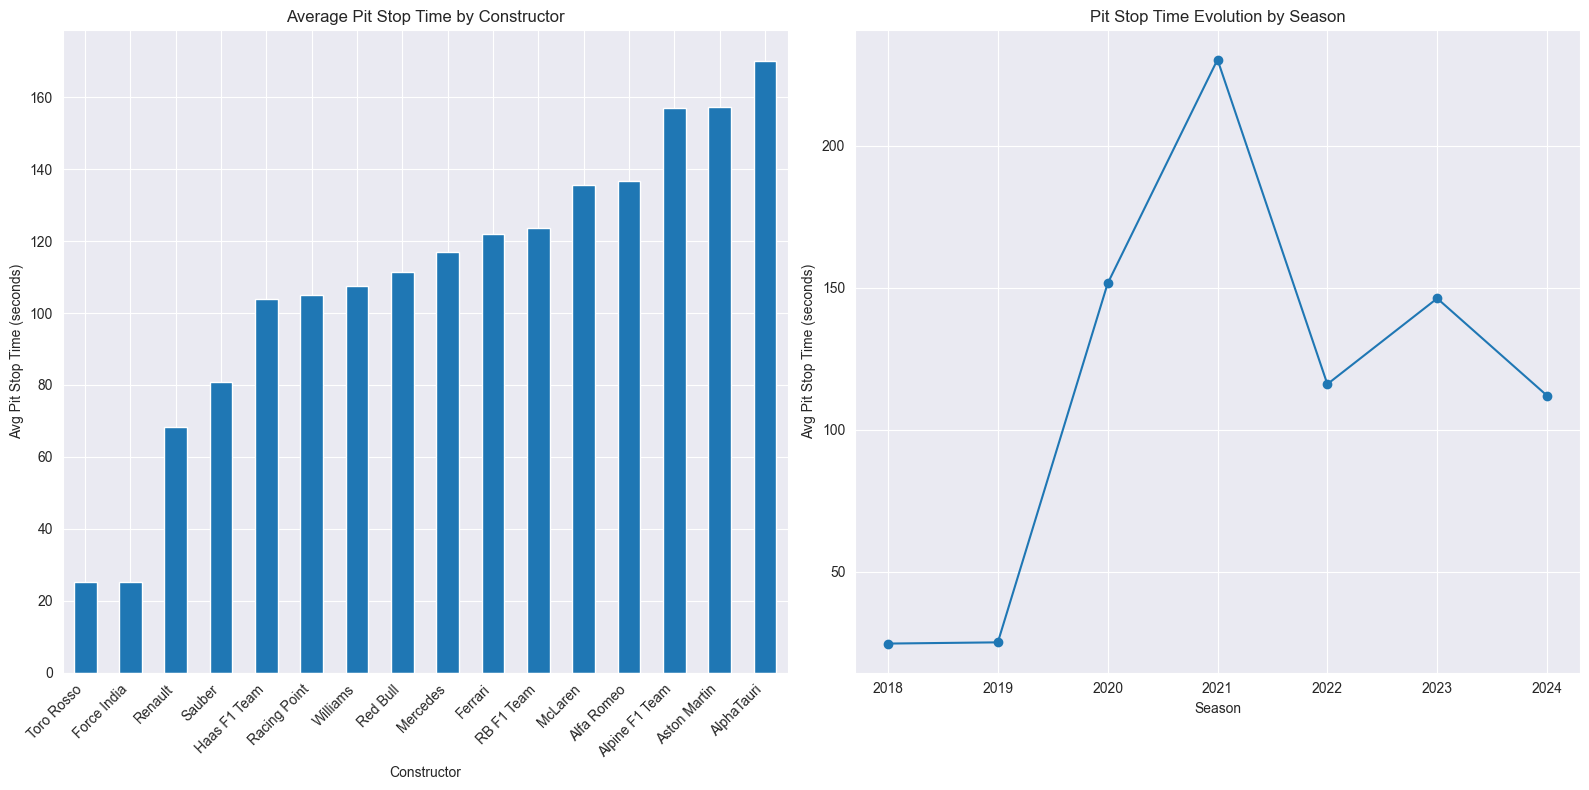

In [33]:
# Create visualization of AvgPitStopTime patterns
plt.figure(figsize=(16, 8))

# Team performance differences
plt.subplot(1, 2, 1)
team_pit_times = df.groupby('Constructor')['AvgPitStopTime'].mean().sort_values()
team_pit_times.plot(kind='bar')

plt.title('Average Pit Stop Time by Constructor')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Avg Pit Stop Time (seconds)')

# Seasonal trends
plt.subplot(1, 2, 2)
season_pit_times = df.groupby('Season')['AvgPitStopTime'].mean()
season_pit_times.plot(kind='line', marker='o')

plt.title('Pit Stop Time Evolution by Season')
plt.xlabel('Season')
plt.ylabel('Avg Pit Stop Time (seconds)')

plt.tight_layout()
plt.show()

In [34]:
for idx in df[df['AvgPitStopTime'].isna()].index:
    constructor = df.loc[idx, 'Constructor']
    circuit = df.loc[idx, 'Circuit']
    season = df.loc[idx, 'Season']

    # Try team-circuit mean (most specific)
    team_circuit_median = df[(df['Constructor'] == constructor) & (df['Circuit'] == circuit) & df['AvgPitStopTime'].notna()]['AvgPitStopTime'].mean()

    if not pd.isna(team_circuit_median):
        df.loc[idx, 'AvgPitStopTime'] = team_circuit_median
        continue

    # Try team-season mean (team's performance in this season)
    team_season_median = df[(df['Constructor'] == constructor) & (df['Season'] == season) & df['AvgPitStopTime'].notna()]['AvgPitStopTime'].mean()

    if not pd.isna(team_season_median):
        df.loc[idx, 'AvgPitStopTime'] = team_season_median
        continue

    # Try circuit median (track-specific effects)
    circuit_median = df[(df['Circuit'] == circuit) &
                        df['AvgPitStopTime'].notna()]['AvgPitStopTime'].median()

    if not pd.isna(circuit_median):
        df.loc[idx, 'AvgPitStopTime'] = circuit_median
        continue

    # Final fallback: global median with seasonal adjustment
    global_median = df['AvgPitStopTime'].mean()
    seasonal_factor = df[df['Season'] == season]['AvgPitStopTime'].mean() / global_median
    
    df.loc[idx, 'AvgPitStopTime'] = global_median * seasonal_factor

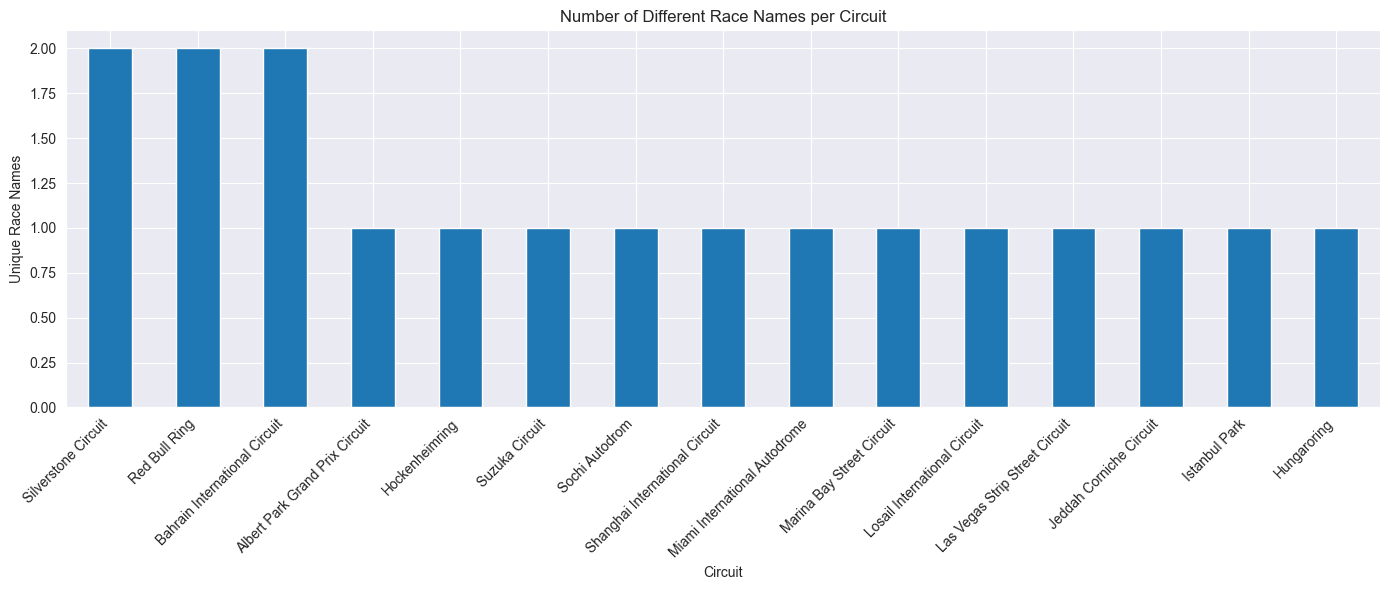


Race names used at Silverstone Circuit:
['British Grand Prix' '70th Anniversary Grand Prix']

Race names used at Red Bull Ring:
['Austrian Grand Prix' 'Styrian Grand Prix']

Race names used at Bahrain International Circuit:
['Bahrain Grand Prix' 'Sakhir Grand Prix']


In [35]:
# Analyze race name patterns
plt.figure(figsize=(14, 6))

# Count number of unique race names per circuit
race_name_counts = df.groupby('Circuit')['Race Name'].nunique().sort_values(ascending=False)
race_name_counts.head(15).plot(kind='bar')

plt.title('Number of Different Race Names per Circuit')
plt.xlabel('Circuit')
plt.ylabel('Unique Race Names')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

# Show which circuits have multiple race names
multi_name_circuits = race_name_counts[race_name_counts > 1].index.tolist()
for circuit in multi_name_circuits[:5]:  # Show top 5 examples
    print(f"\nRace names used at {circuit}:")
    print(df[df['Circuit'] == circuit]['Race Name'].unique())


In [36]:
# Create circuit-to-race-name mapping
circuit_race_names = {}
for circuit in df['Circuit'].unique():
    names = df[df['Circuit'] == circuit]['Race Name'].dropna()
    if not names.empty:
        # Get most common name
        circuit_race_names[circuit] = names.mode()[0]

# Apply primary mapping
for circuit, race_name in circuit_race_names.items():
    mask = (df['Circuit'] == circuit) & (df['Race Name'].isna())
    df.loc[mask, 'Race Name'] = race_name

# Country-based fallback
for idx in df[df['Race Name'].isna()].index:
    circuit = df.loc[idx, 'Circuit']

    # Try to get country
    if 'Country' in df.columns and not pd.isna(df.loc[idx, 'Country']):
        country = df.loc[idx, 'Country']
        df.loc[idx, 'Race Name'] = f"{country} Grand Prix"
    else:
        # Final fallback using circuit name
        df.loc[idx, 'Race Name'] = f"{circuit} Grand Prix"


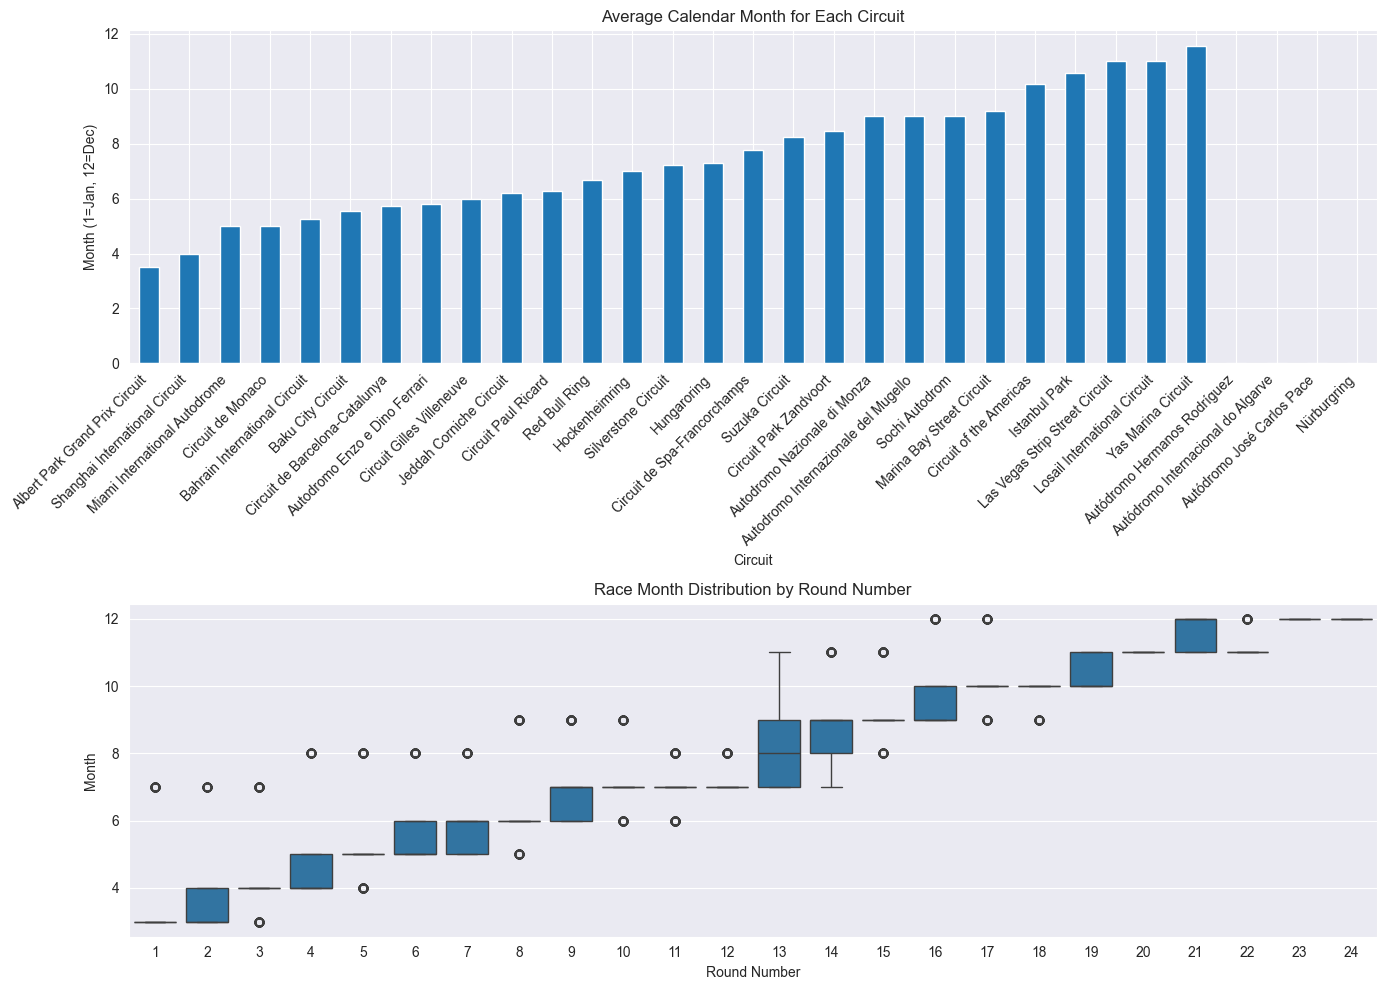

In [37]:
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

    # Create month column for analysis
    df['Month'] = df['Date'].dt.month

    # Visualize race calendar patterns
    plt.figure(figsize=(14, 10))

    # 1. Calendar position of circuits
    plt.subplot(2, 1, 1)
    circuit_months = df.groupby('Circuit')['Month'].mean().sort_values()
    circuit_months.plot(kind='bar')
    plt.title('Average Calendar Month for Each Circuit')
    plt.ylabel('Month (1=Jan, 12=Dec)')
    plt.xticks(rotation=45, ha='right')

    # 2. Round number vs month relationship
    plt.subplot(2, 1, 2)
    sns.boxplot(x='Round', y='Month', data=df)
    plt.title('Race Month Distribution by Round Number')
    plt.xlabel('Round Number')
    plt.ylabel('Month')

    plt.tight_layout()
    plt.show()

    # Remove temporary Month column
    df.drop('Month', axis=1, inplace=True)

In [38]:
# Convert Date to datetime if needed
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

    # Circuit-based date estimation
for idx in df[df['Date'].isna()].index:
    circuit = df.loc[idx, 'Circuit']
    season = df.loc[idx, 'Season']
    round_num = df.loc[idx, 'Round']

    # Try to find typical date for this circuit
    circuit_dates = df[(df['Circuit'] == circuit) & (df['Date'].notna())]['Date']

    if not circuit_dates.empty:
        # Get typical month and day
        typical_month = pd.Series([d.month for d in circuit_dates]).mode()[0]
        typical_day = pd.Series([d.day for d in circuit_dates]).mode()[0]

        # Create estimated date
        estimated_date = pd.Timestamp(year=season, month=typical_month, day=typical_day)
        df.loc[idx, 'Date'] = estimated_date
        continue

    # Try round-based estimation
    season_start = df[(df['Season'] == season) & (df['Round'] == 1) & (df['Date'].notna())]['Date']

    if not season_start.empty:
        # Start with first race date and add ~2 weeks per round
        start_date = season_start.iloc[0]
        estimated_date = start_date + pd.Timedelta(days=(round_num-1)*14)
        df.loc[idx, 'Date'] = estimated_date
        continue

    # Final fallback - rough estimate based on typical F1 calendar
    month_estimate = min(3 + round_num // 2, 12)  # Start in March, ~2 races per month
    day_estimate = 15  # Mid-month as default
    df.loc[idx, 'Date'] = pd.Timestamp(year=season, month=month_estimate, day=day_estimate)

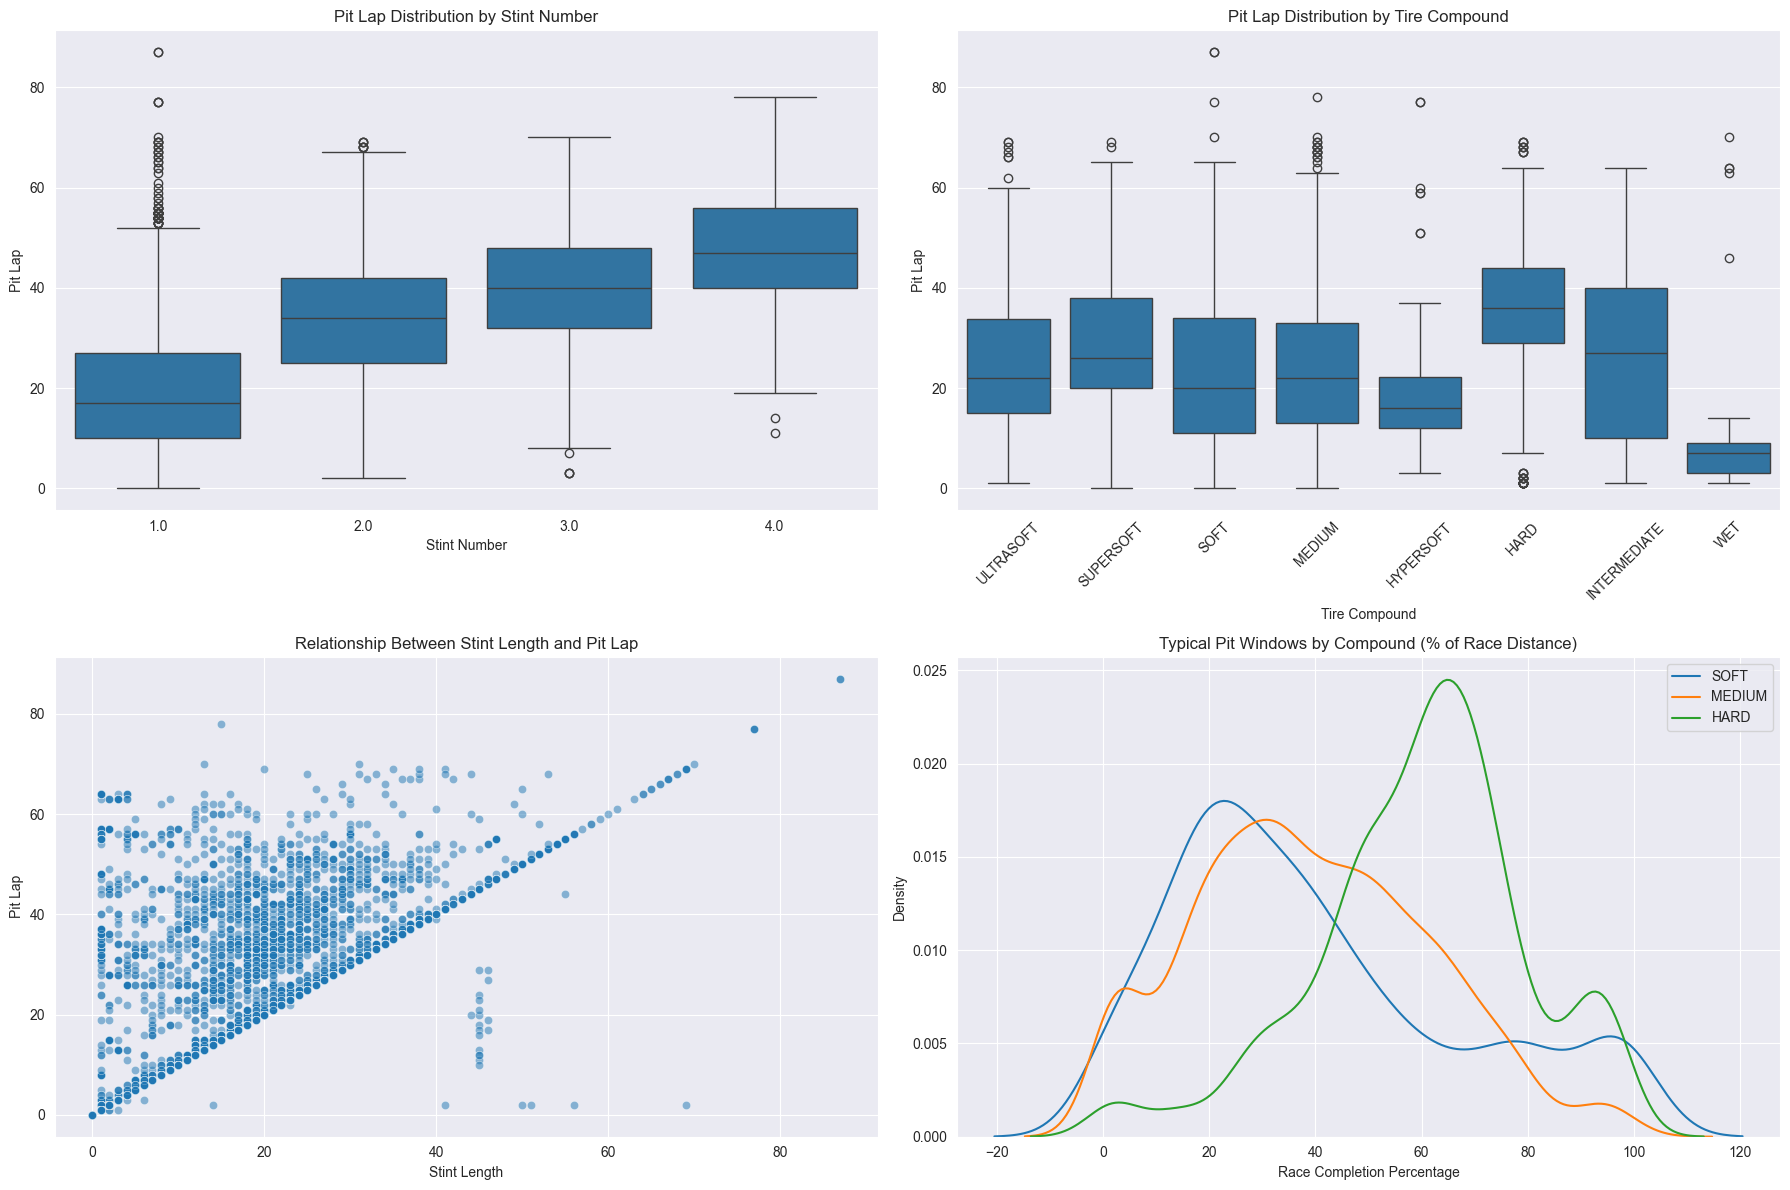

In [39]:
# Analyze Pit_Lap patterns
plt.figure(figsize=(18, 12))

# 1. Pit lap distribution by stint number
plt.subplot(2, 2, 1)
sns.boxplot(x='Stint', y='Pit_Lap', data=df[df['Stint'] <= 4])  # Limit to first 4 stints
plt.title('Pit Lap Distribution by Stint Number')
plt.xlabel('Stint Number')
plt.ylabel('Pit Lap')

# 2. Pit lap distribution by tire compound
plt.subplot(2, 2, 2)
if 'Tire Compound' in df.columns:
    sns.boxplot(x='Tire Compound', y='Pit_Lap', data=df[~df['Is_Final_Stint']])
    plt.title('Pit Lap Distribution by Tire Compound')
    plt.xticks(rotation=45)
    plt.ylabel('Pit Lap')

# 3. Stint Length vs Pit_Lap relationship
plt.subplot(2, 2, 3)
sns.scatterplot(x='Stint Length', y='Pit_Lap', data=df[~df['Is_Final_Stint']], alpha=0.5)
plt.title('Relationship Between Stint Length and Pit Lap')
plt.xlabel('Stint Length')
plt.ylabel('Pit Lap')

# 4. Pit window analysis for specific tire compounds
plt.subplot(2, 2, 4)
if 'Tire Compound' in df.columns:
    # Calculate pit lap as percentage of race distance
    df['Pit_Lap_Pct'] = df['Pit_Lap'] / df.groupby(['Season', 'Round'])['Laps'].transform('max') * 100

    # Show typical pit windows by compound
    key_compounds = ['SOFT', 'MEDIUM', 'HARD']
    compounds_present = [c for c in key_compounds if c in df['Tire Compound'].unique()]

    for compound in compounds_present:
        compound_data = df[(df['Tire Compound'] == compound) & (~df['Is_Final_Stint']) & (df['Pit_Lap_Pct'] <= 100)]
        if not compound_data.empty:
            sns.kdeplot(compound_data['Pit_Lap_Pct'], label=compound)

    plt.title('Typical Pit Windows by Compound (% of Race Distance)')
    plt.xlabel('Race Completion Percentage')
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.show()

# Remove temporary column if created
if 'Pit_Lap_Pct' in df.columns:
    df.drop('Pit_Lap_Pct', axis=1, inplace=True)

* 1-stoppers would pit early in the first 20 laps meaning they most likely had the first stint with a SOFT compound tire probably to have the second as HARDS
* 2/3-stppers meant a quite long track and would most likey be Medium tyres
* 4-stoppers had that extra-stop for either one of the following reasons:
    * changing to the fastest tyres for an extra point for fastest lap, hence probably a higher aggression score
    * pitting to repair some damage 

In [40]:
# First, identify which missing Pit_Lap values remain
missing_pit_laps = df['Pit_Lap'].isna().sum()
print(f"Remaining missing Pit_Lap values: {missing_pit_laps}")

# Create max laps reference
max_laps = df.groupby(['Season', 'Round'])['Laps'].transform('max')

# Handle final stints first
final_stint_missing = df['Is_Final_Stint'] & df['Pit_Lap'].isna()
df.loc[final_stint_missing, 'Pit_Lap'] = max_laps[final_stint_missing]

# For non-final stints, use compound-specific strategy
non_final_missing = (~df['Is_Final_Stint']) & df['Pit_Lap'].isna()

Remaining missing Pit_Lap values: 2701


In [41]:
for idx in df[non_final_missing].index:
    season = df.loc[idx, 'Season']
    round_num = df.loc[idx, 'Round']
    driver = df.loc[idx, 'Driver']
    stint_num = df.loc[idx, 'Stint']

    # Try 1: If Stint Length is available, use that
    if 'Stint Length' in df.columns and not pd.isna(df.loc[idx, 'Stint Length']):
        # Compute sum of previous stint lengths
        prev_stints_mask = ((df['Season'] == season) &
                            (df['Round'] == round_num) &
                            (df['Driver'] == driver) &
                            (df['Stint'] < stint_num))

        prev_stints_length = df.loc[prev_stints_mask, 'Stint Length'].sum()
        df.loc[idx, 'Pit_Lap'] = prev_stints_length + df.loc[idx, 'Stint Length']
        continue

    # Try 2: Use tire compound-specific strategy
    if 'Tire Compound' in df.columns and not pd.isna(df.loc[idx, 'Tire Compound']):
        compound = df.loc[idx, 'Tire Compound']

        # Get typical stint length for this compound
        typical_length = df[(df['Tire Compound'] == compound) &
                            (~df['Is_Final_Stint']) &
                            df['Stint Length'].notna()]['Stint Length'].median()

        if not pd.isna(typical_length):
            # Similar computation to above
            prev_stints_mask = ((df['Season'] == season) &
                                (df['Round'] == round_num) &
                                (df['Driver'] == driver) &
                                (df['Stint'] < stint_num))

            prev_stints_length = df.loc[prev_stints_mask, 'Stint Length'].sum()
            df.loc[idx, 'Pit_Lap'] = prev_stints_length + typical_length
            continue

    # Try 3: Use race-specific median pit lap for this stint number
    race_stint_median = df[(df['Season'] == season) &
                           (df['Round'] == round_num) &
                           (df['Stint'] == stint_num) &
                           df['Pit_Lap'].notna()]['Pit_Lap'].median()

    if not pd.isna(race_stint_median):
        df.loc[idx, 'Pit_Lap'] = race_stint_median
        continue

    # Try 4: Use typical race percentage for this stint number
    if 'Max_Stint' in df.columns:
        # Calculate typical lap percentage for this stint number
        typical_pct = df[(df['Stint'] == stint_num) &
                         df['Pit_Lap'].notna()]['Pit_Lap'].median() / max_laps

        if not pd.isna(typical_pct):
            df.loc[idx, 'Pit_Lap'] = round(typical_pct * max_laps.loc[idx])
            continue

    # Final fallback: Use a reasonable estimate based on stint number
    estimated_pit_lap = round(max_laps.loc[idx] * stint_num / (df.loc[idx, 'Max_Stint'] + 1))
    df.loc[idx, 'Pit_Lap'] = estimated_pit_lap


In [42]:
print(df.isna().sum())

Season                     0
Round                      0
Circuit                    0
Driver                     0
Constructor                0
Laps                       0
Position                   0
TotalPitStops              0
AvgPitStopTime             0
Race Name                  0
Date                       0
Time_of_race               0
Location                   0
Country                    0
Air_Temp_C                 0
Track_Temp_C               0
Humidity_%                 0
Wind_Speed_KMH             0
Lap Time Variation         0
Total Pit Stops            0
Tire Usage Aggression      0
Fast Lap Attempts          0
Position Changes           0
Driver Aggression Score    0
Abbreviation               0
Stint                      0
Tire Compound              0
Stint Length               0
Pit_Lap                    0
Pit_Time                   0
Max_Stint                  0
Is_Final_Stint             0
Race_Completion_Pct        0
dtype: int64


In [43]:
df.to_csv('data/archive/f1_pitstops_2018_2024_clean.csv', encoding='utf-8', index=False)

### Now that's what we'd like to see!

Time for preprocessing

In [44]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, TargetEncoder
from sklearn.decomposition import PCA

from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [45]:
categorical_features = [
    'Circuit', 'Driver', 'Constructor', 'Race Name',
    'Location', 'Country', 'Time_of_race', 'Tire Compound'
]

numerical_features = [
    'Season', 'Round', 'Laps', 'TotalPitStops', 'Total Pit Stops',
    'Air_Temp_C', 'Track_Temp_C', 'Humidity_%', 'Wind_Speed_KMH',
    'Lap Time Variation', 'Tire Usage Aggression', 'Fast Lap Attempts',
    'Position Changes', 'Driver Aggression Score', 'Stint Length',
    'Pit_Lap', 'Pit_Time', 'AvgPitStopTime', 'Stint', 'Race_Completion_Pct'
]


# Target variable
target = 'Position'

# Features to drop (not useful for modeling)
features_to_drop = [
    'Abbreviation',  # Redundant with Driver
    'Date',  # Racing conditions captured by other features
    'Max_Stint',  # Used for imputation
    'Is_Final_Stint',  # Used for imputation
    'Pit_Time_Numeric'  # Already converted to Pit_Time
]

In [46]:
# Verify all features are accounted for
all_features = categorical_features + numerical_features + features_to_drop + [target]
missing_features = [col for col in df.columns if col not in all_features]

print(f"Features not categorized: {missing_features}")

print(f"Present features: {all_features}")

Features not categorized: []
Present features: ['Circuit', 'Driver', 'Constructor', 'Race Name', 'Location', 'Country', 'Time_of_race', 'Tire Compound', 'Season', 'Round', 'Laps', 'TotalPitStops', 'Total Pit Stops', 'Air_Temp_C', 'Track_Temp_C', 'Humidity_%', 'Wind_Speed_KMH', 'Lap Time Variation', 'Tire Usage Aggression', 'Fast Lap Attempts', 'Position Changes', 'Driver Aggression Score', 'Stint Length', 'Pit_Lap', 'Pit_Time', 'AvgPitStopTime', 'Stint', 'Race_Completion_Pct', 'Abbreviation', 'Date', 'Max_Stint', 'Is_Final_Stint', 'Pit_Time_Numeric', 'Position']


In [47]:
# Engineer new features
# 1. Team-Driver combination (unique partnership)
df['Team_Driver'] = df['Constructor'] + '_' + df['Driver']

In [48]:
# 2. Circuit adaptability score (driver performance at specific circuits)
circuit_driver_perf = df.groupby(['Driver', 'Circuit'])['Position'].mean().reset_index()
circuit_driver_perf.columns = ['Driver', 'Circuit', 'Circuit_Adaptability']

df = df.merge(circuit_driver_perf, on=['Driver', 'Circuit'], how='left')

In [49]:
# 3. Weather sensitivity (interaction between weather conditions and performance)
df['Weather_Sensitivity'] = df['Humidity_%'] * df['Wind_Speed_KMH'] / 100

In [50]:
# 4. Pit efficiency (how effective a team's pit stops are)
df['Pit_Efficiency'] = df['TotalPitStops'] / df['Pit_Time'].clip(lower=1)

In [51]:
# 5. Stint strategy complexity (standard deviation of stint lengths)
stint_strategy = df.groupby(['Season', 'Round', 'Driver'])['Stint Length'].agg(['mean', 'std']).reset_index()
stint_strategy.columns = ['Season', 'Round', 'Driver', 'Avg_Stint_Length', 'Stint_Strategy_Complexity']

df = df.merge(stint_strategy, on=['Season', 'Round', 'Driver'], how='left')

In [52]:
def categorize_tire(compound):
    if pd.isna(compound):
        return 'UNKNOWN'
    elif 'SOFT' in str(compound).upper():
        return 'SOFT'
    elif 'MEDIUM' in str(compound).upper():
        return 'MEDIUM'
    elif 'HARD' in str(compound).upper():
        return 'HARD'
    elif 'INTER' in str(compound).upper():
        return 'INTERMEDIATE'
    elif 'WET' in str(compound).upper():
        return 'WET'
    else:
        return 'OTHER'

In [53]:
df['Tire_Category'] = df['Tire Compound'].apply(categorize_tire)

# 2.4 Weather interaction feature
df['Weather_Factor'] = df['Humidity_%'] * df['Wind_Speed_KMH'] / 100

# 2.5 Pit strategy effectiveness
df['Pit_Strategy_Score'] = df['TotalPitStops'] / df['Pit_Time'].clip(lower=1)

# Add engineered features to numerical list
new_numerical_features = ['Circuit_Driver_Performance', 'Constructor_Performance',
                          'Weather_Factor', 'Pit_Strategy_Score']
numerical_features.extend(new_numerical_features)

# Add tire category to categorical features
categorical_features.append('Tire_Category')

In [54]:
X = df.drop(target, axis=1)
y = df[target]